In [1]:
import sys
# !{sys.executable} -m pip install git+https://github.com/zotko/xyz2graph.git
import shap
from collections import Counter

from tqdm.notebook import trange, tqdm
from time import sleep, perf_counter

import os
from glob import glob
import pandas as pd
import numpy as np
import networkx as nx
from scipy.spatial import distance_matrix

# Scikit-learn
from sklearn.model_selection import KFold
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error,mean_absolute_percentage_error
from sklearn.preprocessing import normalize, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


# Reps
from alchemical_cms import genpaddedCMs
from dscribe.descriptors import SOAP
from dscribe.kernels import REMatchKernel
from mendeleev.fetch import fetch_table
from ase.io import read
from Element_PI import VariancePersist
from Element_PI import VariancePersistv1

# from rdkit import DataStructs
# from rdkit import Chem
# from rdkit.Chem import AllChem
# from rdkit.Chem import Draw, MACCSkeys
# from openbabel import openbabel as ob
# from openbabel import pybel

from xyz2graph import MolGraph, to_networkx_graph, to_plotly_figure
# from plotly.offline import offline
#Plotting
import seaborn as sns
sns.set_style()
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.dpi'] = 200


Number of monomers is equivalent to monomers+CO2: True
Using the intersection of the sets of length: 0

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


In [2]:
AA_df=pd.read_excel('20_AA_CO2_interaction_energy_DFT_PBE0D3BJ_def2TZVPP.xlsx',index_col=0,header=None)
AA_df.index=[i.replace(' acid','').capitalize() if 'acid' in i else i.capitalize() for i in AA_df.index]

# rdkit.Chem.rdMolDescriptors.CalcNumRotatableBonds((Mol)mol, (bool)strict) → int


In [3]:
df=pd.read_excel('site_data.xlsx',index_col=0)
sitelist=['A_carboxy', 'A_amine', 'B_carboxy', 'B_amine', 'A_link','B_link', 'A_side', 'B_side']
inter_df=df[sitelist].dropna()
# inter_df[inter_df!=0]=1

In [108]:
df.loc['Arginine-Lysine']

A_carboxy                    0
A_amine                      0
B_carboxy                    0
B_amine                      0
A_link                       0
B_link                       0
A_side                       3
B_side                       0
Interaction_Energy   -6.531635
label                 AA_AA_32
Name: Arginine-Lysine, dtype: object

In [4]:
df['Interaction_Energy'].describe()

count    400.000000
mean      -5.243077
std        0.902996
min       -9.129920
25%       -5.800167
50%       -5.127589
75%       -4.629300
max       -3.255937
Name: Interaction_Energy, dtype: float64

In [5]:


y=pd.read_excel('400_dipeptides_interaction_energy_UPDATED2.xlsx',usecols=[1,2],index_col=0)
y['keypair']=['_'.join(i.split('_')[:3]) for i in y.index]
pairs=pd.DataFrame([(i[0].split(":")[0],i[0].split(":")[1].replace(" ","").replace('acid','')) for i in pd.read_excel('400_dipeptides_interaction_energy_UPDATED2.xlsx', 'Sheet2',header=None).values]).set_index(0)


# Find set of files
monomerfiles={}        
co2files={}
for k,v in pairs.to_dict()[1].items():
    try:
        path=glob(f'./dipeptides_co2_coordinates/{k}_*.xyz')[0]
        monpath=f'./dipeptides_coordinates/{k}.xyz'
        if os.path.exists(path) and os.path.exists(monpath):
            co2files[v]=path    
            monomerfiles[v]=monpath
    except:
        print(k)
        
# Name check
co2check=['_'.join(i.split('/')[-2].split('_')[:3]) for i in co2files.values()]
moncheck=['_'.join(i.split('/')[-2].split('_')[:4]) for i in monomerfiles.values()]

In [6]:
AAs=sorted(set([i[0].split('-')[0].replace('acid','') for i in pairs.values]))

In [7]:
noncarboyx=inter_df[(inter_df[['A_carboxy','B_carboxy']]==0).all(axis=1)]

In [8]:
noncarboyx

,A_carboxy,A_amine,B_carboxy,B_amine,A_link,B_link,A_side,B_side
Alanine-Lysine,0,0,0,1,0,0,0,2
Arginine-Aspartic,0,0,0,0,0,0,0,3
Arginine-Cysteine,0,0,0,0,0,0,3,0
Arginine-Lysine,0,0,0,0,0,0,3,0
Arginine-Phenylalanine,0,1,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...
Tryptophan-Proline,0,0,0,0,0,0,3,0
Tryptophan-Tryptophan,0,0,0,0,0,0,0,3
Tyrosine-Arginine,0,0,0,2,0,0,0,1
Tyrosine-Lysine,0,1,0,0,0,0,0,2


In [9]:

co2dipepgraphs={}
co2mgs={}
for k,v in co2files.items():
    # Create the MolGraph object
    mg = MolGraph()

    # Read the data from the .xyz file
    mg.read_xyz(v)
    co2mgs[k]=mg
    # Convert the molecular graph to the NetworkX graph
    G = to_networkx_graph(mg)
    co2dipepgraphs[k]=G
    
dipepgraphs={}    
mgs={}
for k,v in monomerfiles.items():
    # Create the MolGraph object
    mg = MolGraph()

    # Read the data from the .xyz file
    mg.read_xyz(v)
    mgs[k]=mg
    # Convert the molecular graph to the NetworkX graph
    G = to_networkx_graph(mg)
    dipepgraphs[k]=G    


In [10]:
# FLAG!
# df.loc['Asparagine-Alanine']
# fig = to_plotly_figure(co2mgs['Asparagine-Alanine'])
# offline.plot(fig)

# FLAG THIS ONE!!
# fig = to_plotly_figure(co2mgs['Alanine-Lysine'])
# offline.plot(fig)

In [11]:
for k,v in pairs.to_dict()[1].items():
    names=v.split('-')
    for j in names:
        if 'acid' in j:
            print(names)

In [12]:
AAs

['Alanine',
 'Arginine',
 'Asparagine',
 'Aspartic',
 'Cysteine',
 'Glutamic',
 'Glutamine',
 'Glycine',
 'Histidine',
 'Isoleucine',
 'Leucine',
 'Lysine',
 'Methionine',
 'Phenylalanine',
 'Proline',
 'Serine',
 'Threonine',
 'Tryptophan',
 'Tyrosine',
 'Valine']

In [13]:
df.loc['Glycine-Proline']['Interaction_Energy']

-3.3692837

In [14]:
df.loc['Glycine-Proline']['label']

'AA_AA_155'

In [15]:
AA_df.loc['Glycine'],AA_df.loc['Proline']

(1   -3.82
 Name: Glycine, dtype: float64,
 1   -4.25
 Name: Proline, dtype: float64)

In [16]:
# pca = PCA(n_components=2)
# pca_result = pca.fit_transform(X)

# pcadf['pca-one'] = pca_result[:,0]
# pcadf['pca-two'] = pca_result[:,1] 
# # pcadf['pca-three'] = pca_result[:,2]
# print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))
# print(sum(pca.explained_variance_ratio_))
# plt.figure(figsize=(16,10))
# sns.scatterplot(
#     x="pca-one", y="pca-two",
#     # hue='A_side',
#     palette=sns.color_palette("hls", 8),
#     data=pcadf,
#     legend="full"
# )

# # sns.scatterplot(
# #     x="pca-one", y="pca-three",
# #     hue='Interaction_Energy',
# #     palette=sns.color_palette("hls", 8),
# #     data=pcadf,
# #     legend="full"
# # )


In [17]:
sorted_IE={}
all_energies=pd.DataFrame(columns=AAs,index=AAs)
IE_df=pd.DataFrame(columns=AAs,index=AAs)
glygly_df=pd.DataFrame(columns=AAs,index=AAs)
for A in AAs:
    sorted_IE[A]={B:df['Interaction_Energy'].to_dict()['-'.join((A,B))] for B in AAs}
    for B in AAs:
        IE_df[A].loc[B]=df['Interaction_Energy'].to_dict()['-'.join((A,B))]-df['Interaction_Energy'].to_dict()['-'.join((A,A))]
        glygly_df[A].loc[B]=df['Interaction_Energy'].to_dict()['-'.join((A,B))]-df['Interaction_Energy'].to_dict()['-'.join(('Glycine','Glycine'))]
        all_energies[A].loc[B]=df['Interaction_Energy'].to_dict()['-'.join((A,B))]

/var/folders/px/qyhp9b8j4bb0z5wgydzgkpxw0000gn/T/ipykernel_3251/4294904025.py:8: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  IE_df[A].loc[B]=df['Interaction_Energy'].to_dict()['-'.join((A,B))]-df['Interaction_Energy'].to_dict()['-'.join((A

In [18]:
df['Interaction_Energy'].describe().to_excel('describe_dipep_IE.xlsx')

In [19]:
minDF=pd.DataFrame([all_energies.astype(float).idxmax(),all_energies.astype(float).max()]).T.rename(columns={0:'idxmin',1:'min'})

In [20]:
minDF['idxmin'][minDF['idxmin']=='Glycine']

Alanine       Glycine
Asparagine    Glycine
Aspartic      Glycine
Cysteine      Glycine
Leucine       Glycine
Methionine    Glycine
Proline       Glycine
Threonine     Glycine
Valine        Glycine
Name: idxmin, dtype: object

In [21]:
df.loc[[f'{k}-{v}' for k,v in minDF['idxmin'][minDF['idxmin']=='Glycine'].to_dict().items()]].sum()

A_carboxy                                                             9
A_amine                                                               1
B_carboxy                                                            10
B_amine                                                               4
A_link                                                                0
B_link                                                                0
A_side                                                                3
B_side                                                                0
Interaction_Energy                                           -32.450688
label                 AA_AA_8AA_AA_48AA_AA_68AA_AA_88AA_AA_208AA_AA_...
dtype: object

In [22]:
maxDF=pd.DataFrame([all_energies.astype(float).idxmin(),all_energies.astype(float).min()]).T.rename(columns={0:'idxmax',1:'max'})

In [23]:
maxDF

,idxmax,max
Alanine,Histidine,-6.153144
Arginine,Isoleucine,-6.775149
Asparagine,Cysteine,-8.385684
Aspartic,Asparagine,-6.254249
Cysteine,Valine,-5.952468
Glutamic,Asparagine,-8.313269
Glutamine,Glutamic,-7.228973
Glycine,Asparagine,-5.795107
Histidine,Glutamic,-7.889352
Isoleucine,Proline,-9.12992


In [24]:
sum([[f'{k} {v:.4f} kcal/mol'] for k,v in maxDF['max'].astype(float).describe().to_dict().items()],[])

['count 20.0000 kcal/mol',
 'mean -7.1380 kcal/mol',
 'std 0.9374 kcal/mol',
 'min -9.1299 kcal/mol',
 '25% -7.8751 kcal/mol',
 '50% -6.9604 kcal/mol',
 '75% -6.5202 kcal/mol',
 'max -5.7951 kcal/mol']

In [25]:
aa_color_dct=dict(zip(AA_df.index,sns.color_palette('Paired',len(AA_df))))

In [26]:
df.loc[[f"{k}-{v}" for k,v in minDF['idxmin'].to_dict().items()]]['Interaction_Energy'].describe()

count    20.000000
mean     -3.736495
std       0.426222
min      -4.777702
25%      -3.880914
50%      -3.576564
75%      -3.419890
max      -3.255937
Name: Interaction_Energy, dtype: float64

In [27]:
df.loc[[f"{k}-{v}" for k,v in maxDF['idxmax'].to_dict().items()]]['Interaction_Energy'].describe()

count    20.000000
mean     -7.138008
std       0.937389
min      -9.129920
25%      -7.875108
50%      -6.960401
75%      -6.520172
max      -5.795107
Name: Interaction_Energy, dtype: float64

In [28]:
df

,A_carboxy,A_amine,B_carboxy,B_amine,A_link,B_link,A_side,B_side,Interaction_Energy,label
Alanine-Alanine,0,0,2,1,0,0,0,0,-4.032639,AA_AA_1
Alanine-Arginine,0,0,1,1,0,0,0,1,-5.392723,AA_AA_2
Alanine-Asparagine,2,0,0,0,0,0,0,1,-5.716392,AA_AA_3
Alanine-Aspartic,2,0,0,0,0,1,0,0,-5.247079,AA_AA_4
Alanine-Cysteine,2,0,0,0,0,0,0,1,-4.872244,AA_AA_5
...,...,...,...,...,...,...,...,...,...,...
Valine-Serine,0,1,1,0,1,0,0,0,-5.861945,AA_AA_396
Valine-Threonine,1,0,0,0,0,0,1,1,-4.461757,AA_AA_397
Valine-Tryptophan,2,1,0,0,0,0,0,0,-5.625054,AA_AA_398
Valine-Tyrosine,1,1,0,0,0,0,0,1,-4.655518,AA_AA_399


In [29]:
df.loc[[i[0]+'-'+i[1] for i in minDF.reset_index().to_numpy()]].sum()

A_carboxy                                                            31
A_amine                                                               1
B_carboxy                                                            12
B_amine                                                               5
A_link                                                                0
B_link                                                                1
A_side                                                                7
B_side                                                                3
Interaction_Energy                                           -74.729891
label                 AA_AA_8AA_AA_40AA_AA_48AA_AA_68AA_AA_88AA_AA_1...
dtype: object

In [30]:
df.loc[[i[0]+'-'+i[1] for i in maxDF.reset_index().to_numpy()]].sum()

A_carboxy                                                            15
A_amine                                                               6
B_carboxy                                                            10
B_amine                                                               2
A_link                                                                1
B_link                                                                1
A_side                                                                7
B_side                                                               18
Interaction_Energy                                          -142.760156
label                 AA_AA_9AA_AA_30AA_AA_45AA_AA_63AA_AA_100AA_AA_...
dtype: object

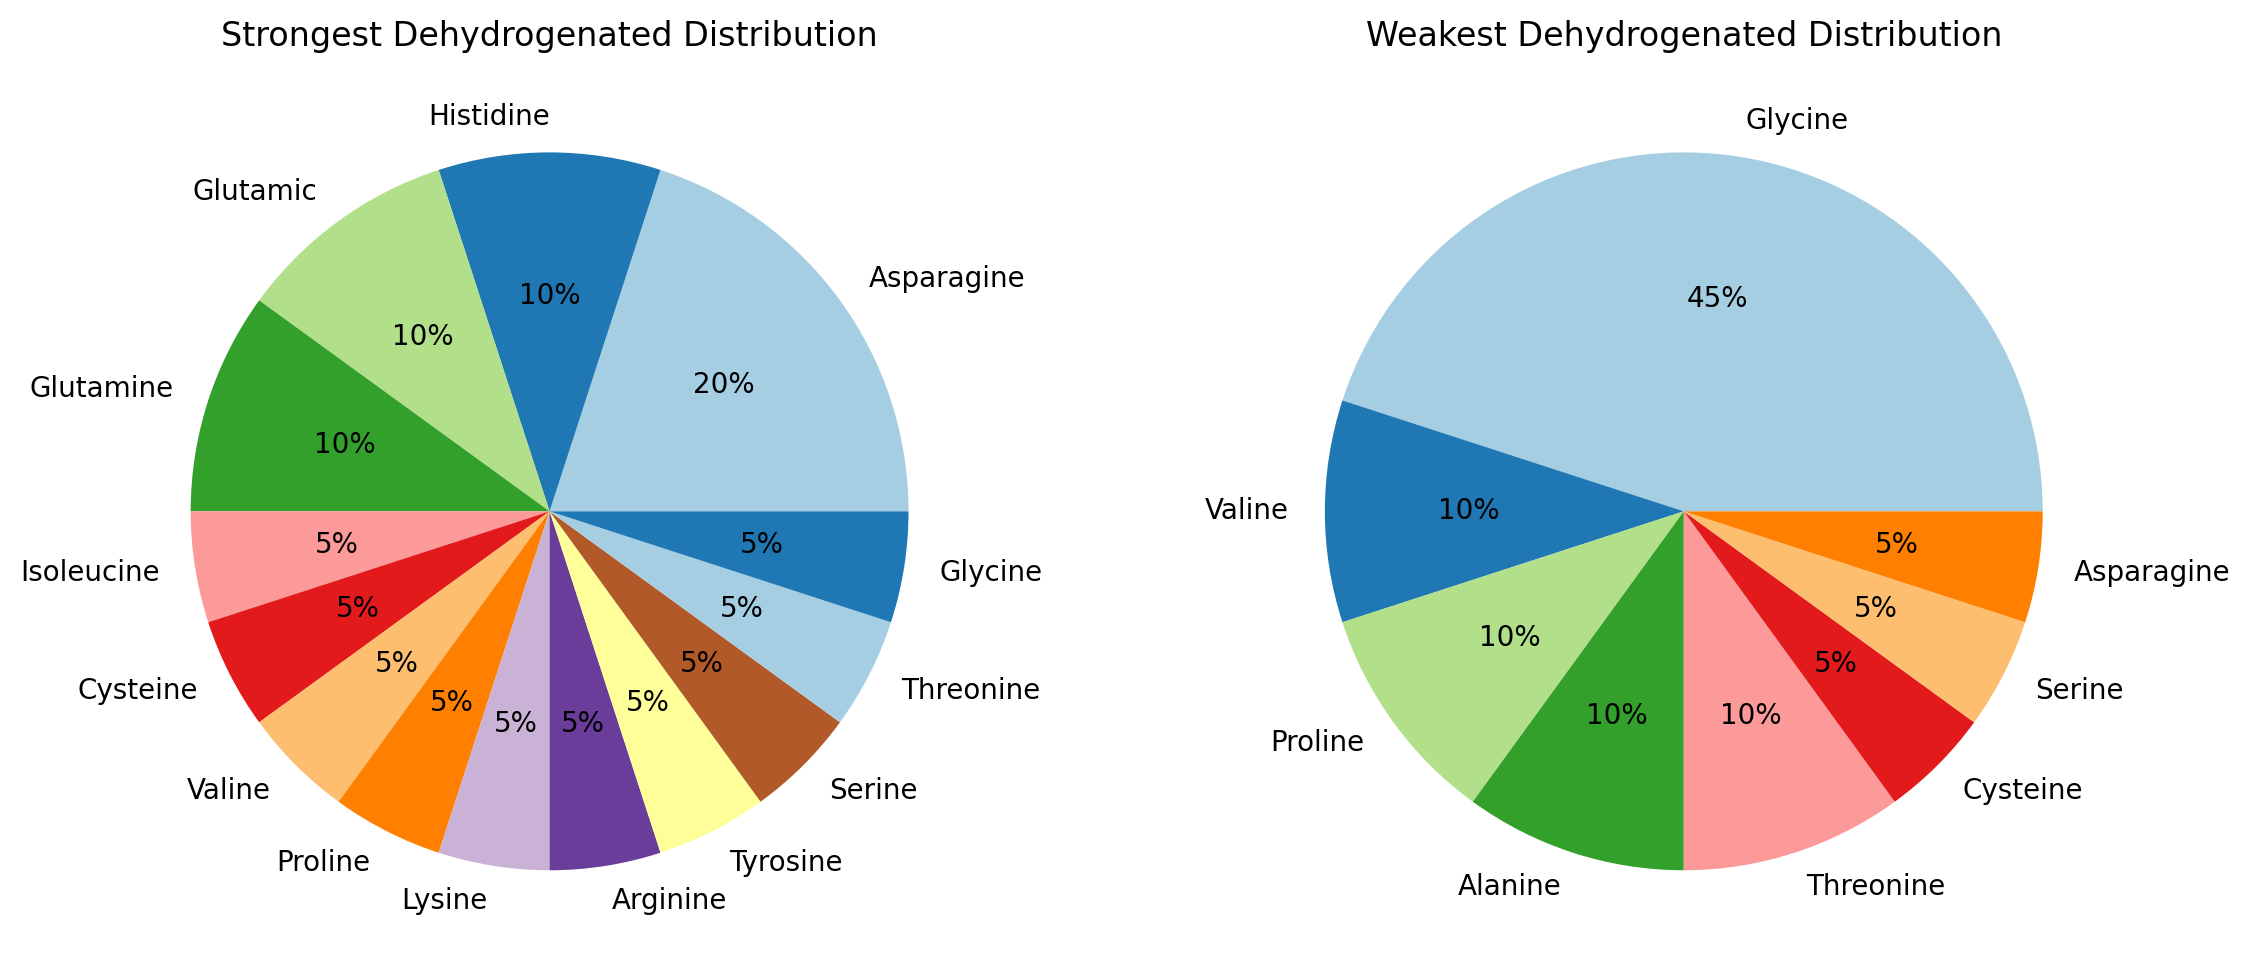

In [31]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,5))

cntidmin=minDF['idxmin'].value_counts()
mincmap=sns.color_palette('Paired',len(cntidmin))
ax2.pie(cntidmin.values, labels = cntidmin.index, autopct='%.0f%%',colors=mincmap)
ax2.set_title('Weakest Dehydrogenated Distribution')

cntidmax=maxDF['idxmax'].value_counts()
maxcmap=sns.color_palette('Paired',len(cntidmax)-1)+[sns.color_palette('Paired',2)[1]]
ax1.pie(cntidmax.values, labels = cntidmax.index, autopct='%.0f%%',colors=maxcmap)
ax1.set_title('Strongest Dehydrogenated Distribution')
plt.tight_layout()
plt.savefig('dehydrogenated_dis.png',dpi=300,bbox_inches='tight')
plt.show()




In [32]:
df.loc[['-'.join(i) for i in minDF['idxmin'].reset_index().to_numpy() if i[1]=='Glycine']][sitelist].sum().sort_values()

A_link        0
B_link        0
B_side        0
A_amine       1
A_side        3
B_amine       4
A_carboxy     9
B_carboxy    10
dtype: int64

In [33]:
['-'.join(i) for i in minDF['idxmin'].reset_index().to_numpy() if i[1]=='Glycine']

['Alanine-Glycine',
 'Asparagine-Glycine',
 'Aspartic-Glycine',
 'Cysteine-Glycine',
 'Leucine-Glycine',
 'Methionine-Glycine',
 'Proline-Glycine',
 'Threonine-Glycine',
 'Valine-Glycine']

In [34]:
df[sitelist].loc[["-".join(i) for i in np.vstack([maxDF['idxmax'].reset_index().to_numpy()[maxDF['idxmax'].reset_index().to_numpy()[:,1]==B] for B in ["Histidine","Glutamic","Glutamine"]])]].sum().sort_values()

B_amine      0
A_link       0
B_link       1
A_side       1
A_amine      2
B_carboxy    2
B_side       5
A_carboxy    7
dtype: int64

In [35]:
df.loc[['-'.join(i) for i in maxDF['idxmax'].reset_index().to_numpy() if i[1]=='Asparagine']][sitelist].sum().sort_values()


B_amine      0
A_link       0
B_link       0
A_side       0
A_amine      1
B_carboxy    1
A_carboxy    4
B_side       6
dtype: int64

In [36]:
['-'.join(i) for i in maxDF['idxmax'].reset_index().to_numpy() if i[1]=='Asparagine']


['Aspartic-Asparagine',
 'Glutamic-Asparagine',
 'Glycine-Asparagine',
 'Leucine-Asparagine']

In [37]:
outliers=df['Interaction_Energy'][df['Interaction_Energy']<df['Interaction_Energy'].describe()['25%']-1.5*(df['Interaction_Energy'].describe()['75%']-df['Interaction_Energy'].describe()['25%'])].index

In [38]:
df['Interaction_Energy'].loc[outliers]

Asparagine-Cysteine    -8.385684
Glutamic-Asparagine    -8.313269
Histidine-Glutamic     -7.889352
Isoleucine-Proline     -9.129920
Proline-Tyrosine       -8.273217
Tryptophan-Threonine   -7.636904
Tyrosine-Glycine       -7.870359
Name: Interaction_Energy, dtype: float64

In [39]:
df['Interaction_Energy'].idxmin(),df['Interaction_Energy'].min().round(2)

('Isoleucine-Proline', -9.13)

In [40]:
df['Interaction_Energy'].idxmax(),df['Interaction_Energy'].max().round(2)

('Serine-Serine', -3.26)

In [41]:
df['Interaction_Energy'].describe().round(2)

count    400.00
mean      -5.24
std        0.90
min       -9.13
25%       -5.80
50%       -5.13
75%       -4.63
max       -3.26
Name: Interaction_Energy, dtype: float64

In [42]:
AA_df.describe().round(2)

,1
count,20.00
mean,-4.69
std,0.73
min,-6.24
25%,-5.08
50%,-4.58
75%,-4.08
max,-3.82


In [43]:
all_energies.astype(float).describe().loc['max'].describe().round(2)

count    20.00
mean     -3.74
std       0.43
min      -4.78
25%      -3.88
50%      -3.58
75%      -3.42
max      -3.26
Name: max, dtype: float64

In [44]:
all_energies.astype(float).describe().loc['min'].describe().round(2)

count    20.00
mean     -7.14
std       0.94
min      -9.13
25%      -7.88
50%      -6.96
75%      -6.52
max      -5.80
Name: min, dtype: float64

In [45]:
df['Interaction_Energy'].describe()

count    400.000000
mean      -5.243077
std        0.902996
min       -9.129920
25%       -5.800167
50%       -5.127589
75%       -4.629300
max       -3.255937
Name: Interaction_Energy, dtype: float64

In [46]:
IQR=df['Interaction_Energy'].quantile(0.75)-df['Interaction_Energy'].quantile(0.25)

In [47]:
df['Interaction_Energy'].quantile(0.25)-1.5*IQR

-7.5564677625000005

/var/folders/px/qyhp9b8j4bb0z5wgydzgkpxw0000gn/T/ipykernel_3251/4247484735.py:2: UserWarning: The palette list has more values (12) than needed (2), which may not be intended.
  sns.boxplot(data=pd.concat([AA_df,df['Interaction_Energy']]).rename(columns={"Interaction_Energy":'Dipeptides',1:'Amino Acids'}),ax=ax1,palette=sns.color_palette('Paired'))
/var/folders/px/qyhp9b8j4bb0z5wgydzgkpxw0000gn/T/ipykernel_3251/4247484735.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation = 90, ha="center")
/var/folders/px/qyhp9b8j4bb0z5wgydzgkpxw0000gn/T/ipykernel_3251/4247484735.py:7: UserWarning: 
The palette list has fewer values (12) than needed (20) and will cycle, which may produce an uninterpretable plot.
  sns.boxplot(data=all_energies,ax=ax2,palette=sns.color_palette('Paired'))
/var/folders/px/qyhp9b8j4bb0z5wgydzgkpxw0000gn/T/ipykernel_3251/4247484735.py:8: 

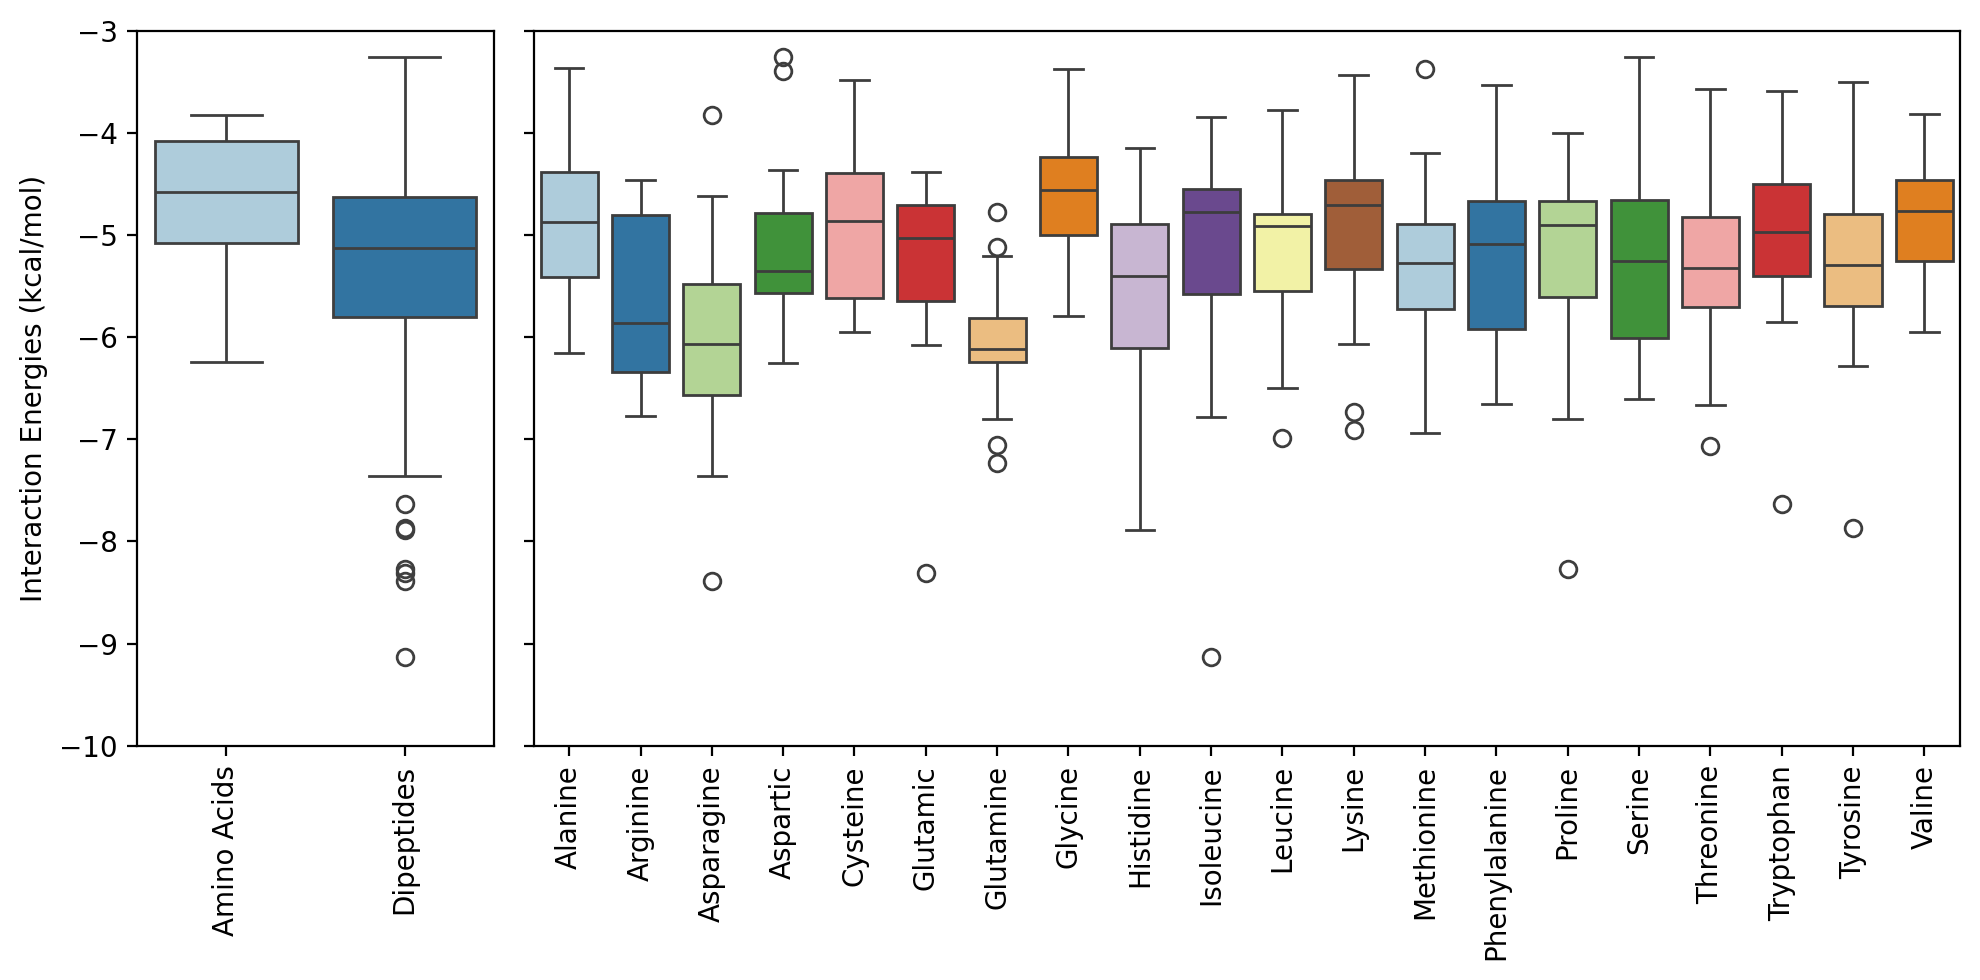

In [48]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5),sharey=True, gridspec_kw={'width_ratios': [1, 4]})
sns.boxplot(data=pd.concat([AA_df,df['Interaction_Energy']]).rename(columns={"Interaction_Energy":'Dipeptides',1:'Amino Acids'}),ax=ax1,palette=sns.color_palette('Paired'))

ax1.set_ylim(-10,-3)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation = 90, ha="center")
ax1.set_ylabel('Interaction Energies (kcal/mol)')
sns.boxplot(data=all_energies,ax=ax2,palette=sns.color_palette('Paired'))
ax2.set_xticklabels(ax2.get_xticklabels(), rotation = 90, ha="center")

plt.tight_layout()
plt.savefig('boxplot_IEs_vs_AAs.png',dpi=300,bbox_inches='tight')

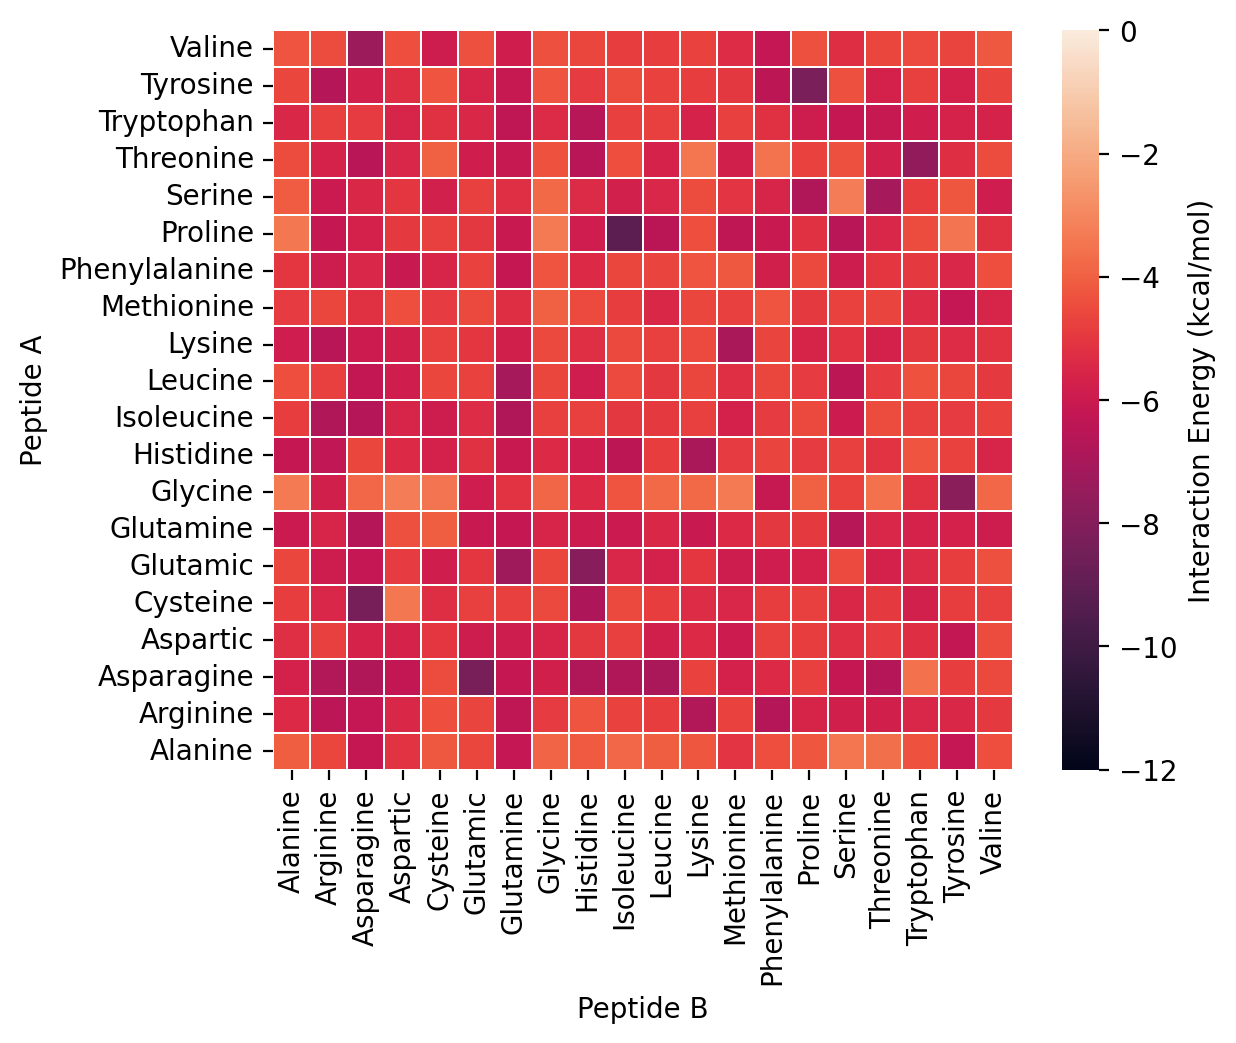

In [49]:

ax=sns.heatmap(data=all_energies.astype(float),cmap=sns.cm.rocket, linewidth=.01,cbar_kws={'label': 'Interaction Energy (kcal/mol)'}, vmin=-12, vmax=0,square=True)
ax.invert_yaxis()
plt.xlabel('Peptide B')
plt.ylabel('Peptide A')
plt.savefig('pair_heat.png',dpi=300,bbox_inches='tight')
plt.show()

In [50]:
palette=sns.color_palette('Paired',20)
markers=['o','x','^','1','*']

In [51]:
from matplotlib import cm
from matplotlib.ticker import LinearLocator


data_3D=[]
for idx,A in enumerate(AA_df.index):
    for idxb,B in enumerate(AA_df.index):
        data_3D.append([AA_df.loc[A].values[0],AA_df.loc[B].values[0],all_energies[A][B]])
data_3D=np.array(data_3D)

X=data_3D[:,0]
Y=data_3D[:,1]
Z=data_3D[:,2].reshape(-1,1)



# fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
# ax.scatter(X, Y, Z)
# # X, Y = np.meshgrid(X, Y)

# # # Plot the surface.
# # surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
# #                        linewidth=0, antialiased=False)

# # # Customize the z axis.
# # # ax.set_zlim(-1.01, 1.01)
# # ax.zaxis.set_major_locator(LinearLocator(10))
# # # A StrMethodFormatter is used automatically
# # ax.zaxis.set_major_formatter('{x:.02f}')

# # # Add a color bar which maps values to colors.
# # fig.colorbar(surf, shrink=0.5, aspect=5)

# # Rotate the axes and update
# for angle in range(0, 360*4 + 1):
#     # Normalize the angle to the range [-180, 180] for display
#     angle_norm = (angle + 180) % 360 - 180

#     # Cycle through a full rotation of elevation, then azimuth, roll, and all
#     elev = azim = roll = 0
#     if angle <= 360:
#         elev = angle_norm
#     elif angle <= 360*2:
#         azim = angle_norm
#     elif angle <= 360*3:
#         roll = angle_norm
#     else:
#         elev = azim = roll = angle_norm

#     # Update the axis view and title
#     ax.view_init(elev, azim, roll)
#     plt.title('Elevation: %d°, Azimuth: %d°, Roll: %d°' % (elev, azim, roll))

#     plt.draw()
#     plt.pause(.001)

# # plt.show()


In [52]:
greaterdehydroxy=pd.concat([(all_energies[A]<=AA_df.loc[A].values[0]).value_counts() for idx,A in enumerate(AA_df.index)],axis=1)
greaterdehydro=pd.concat([(all_energies.T[A]<=AA_df.loc[A].values[0]).value_counts() for idx,A in enumerate(AA_df.index)],axis=1)
greaterdehydroxy_int=greaterdehydroxy.T.sum()
greaterdehydro_int=pd.concat([(all_energies.T[A]<=AA_df.loc[A].values[0]).value_counts() for idx,A in enumerate(AA_df.index)],axis=1).T.sum()

In [53]:
df[sitelist].loc[[f'Leucine-{i}' for i in all_energies['Leucine'][AA_df.loc['Leucine'].values[0]<all_energies['Leucine']].index]].sum().sort_values()

A_amine       0
A_link        0
B_link        1
B_amine       6
A_side        7
B_carboxy    10
B_side       11
A_carboxy    19
dtype: int64

In [54]:
df[sitelist].loc[[f'Arginine-{i}' for i in all_energies['Arginine'][AA_df.loc['Arginine'].values[0]<all_energies['Arginine']].index]].sum().sort_values()

B_link        0
B_amine       1
A_link        1
A_amine       2
B_carboxy     5
A_side        9
A_carboxy    11
B_side       13
dtype: int64

In [55]:
all_energies.loc[['Leucine','Arginine']]

,Alanine,Arginine,Asparagine,Aspartic,Cysteine,Glutamic,Glutamine,Glycine,Histidine,Isoleucine,Leucine,Lysine,Methionine,Phenylalanine,Proline,Serine,Threonine,Tryptophan,Tyrosine,Valine
Leucine,-4.406323,-4.751297,-6.27577,-5.820056,-4.617431,-4.701178,-7.05393,-4.628204,-5.889654,-4.541969,-5.009342,-4.600912,-5.207944,-4.610531,-4.909183,-6.405307,-4.884668,-4.338906,-4.627839,-4.933344
Arginine,-5.392723,-6.424013,-6.195343,-5.470038,-4.425922,-4.648634,-6.367689,-4.883341,-4.26918,-4.696376,-4.860229,-6.733916,-4.71533,-6.650854,-5.600397,-5.771862,-5.800714,-5.503352,-5.461052,-4.961139


In [56]:
all_energies[['Leucine','Arginine']]

,Leucine,Arginine
Alanine,-4.07243,-4.61971
Arginine,-4.860229,-6.424013
Asparagine,-6.98373,-6.72503
Aspartic,-5.771067,-4.822591
Cysteine,-4.860112,-5.504983
Glutamic,-5.707557,-5.930735
Glutamine,-5.470807,-5.56053
Glycine,-3.774012,-5.799984
Histidine,-4.836956,-6.311198
Isoleucine,-4.948952,-6.775149


In [57]:
[[all_energies[A].loc[(all_energies[A]>=AA_df.loc[A].values[0])],AA_df.loc[A].values[0]] for idx,A in enumerate(AA_df.index)]

[[Glycine   -3.359185
  Proline   -3.383607
  Name: Alanine, dtype: object,
  -3.86],
 [Alanine          -4.61971
  Aspartic        -4.822591
  Cysteine        -5.504983
  Glutamic        -5.930735
  Glutamine        -5.56053
  Glycine         -5.799984
  Leucine         -4.751297
  Methionine      -4.624209
  Phenylalanine   -5.917163
  Proline         -6.158251
  Serine          -6.040805
  Threonine       -5.632662
  Tryptophan      -4.743817
  Valine          -4.455854
  Name: Arginine, dtype: object,
  -6.24],
 [Aspartic        -5.633229
  Glycine         -3.823159
  Histidine       -4.615603
  Methionine      -5.167721
  Phenylalanine   -5.485625
  Proline         -5.707686
  Serine          -5.474625
  Tryptophan      -4.910653
  Name: Asparagine, dtype: object,
  -5.72],
 [Alanine      -5.133679
  Cysteine     -3.387374
  Glutamic     -4.896437
  Glutamine    -4.364795
  Glycine      -3.258298
  Methionine    -4.44424
  Proline      -4.930657
  Serine       -5.033724
  Valine  

In [58]:
greaterdehydro.T[False].dropna().sort_values()

count     1.0
count     2.0
count     3.0
count     3.0
count     4.0
count     5.0
count     8.0
count     8.0
count     8.0
count     8.0
count     8.0
count     9.0
count    11.0
count    16.0
count    17.0
Name: False, dtype: float64

In [59]:
melt_dipEs=all_energies.reset_index().melt(id_vars='index').rename(columns={'index':'B','variable':'A','value':'Interaction'})

In [60]:
AA_df

,1
Alanine,-3.86
Arginine,-6.24
Asparagine,-5.72
Aspartic,-5.20
Cysteine,-3.82
Glutamic,-5.29
Glutamine,-4.75
Glycine,-3.82
Histidine,-4.79
Isoleucine,-4.09


In [61]:
avgpercent_bars=[]
for A in AA_df.index:
    for B in AA_df.index:
        avgpercent_bars.append((A,B,np.mean([100*((all_energies[A][B]-AA_df.loc[A])/AA_df.loc[A]).values[0],100*((all_energies[A][B]-AA_df.loc[B])/AA_df.loc[B]).values[0]])))
avgpercentdf=pd.DataFrame(avgpercent_bars,columns=['A','B','Average Percent Improvement'])        

In [62]:
mean_avgpercentdf=pd.DataFrame.from_dict({A:avgpercentdf[((avgpercentdf['A']==A)|(avgpercentdf['B']==A))].rename(columns={'Average Percent Improvement':A})[A].values for A in AA_df.index},orient='columns').describe().loc['mean'].sort_values().reset_index()

In [63]:
mean_avgpercentdf.loc[mean_avgpercentdf['mean'].nlargest(5).index].round(0)['index'].tolist()

['Glutamine', 'Isoleucine', 'Cysteine', 'Proline', 'Tryptophan']

## ax=sns.violinplot(data=pd.DataFrame.from_dict({A:avgpercentdf[((avgpercentdf['A']==A)|(avgpercentdf['B']==A))].rename(columns={'Average Percent Improvement':A})[A].values for A in AA_df.index},orient='columns'),palette=sns.color_palette('Paired',20))
plt.plot(mean_avgpercentdf['index'],mean_avgpercentdf['mean'],'rx')
sns.lineplot(data=pd.DataFrame([np.arange(-10,30,1),np.zeros(len(np.arange(-10,30,1)))]).T,x=0,y=1,color='k',linestyle=':')
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=90, ha='center')
ax.set_ylabel('Percent Improvement (%)')
ax.set_xlabel('Amino Acids')
ax.set_xlim(-1,20)
plt.tight_layout()
plt.savefig('overall_percent_imp.png',dpi=300,bbox_inches='tight')


/var/folders/px/qyhp9b8j4bb0z5wgydzgkpxw0000gn/T/ipykernel_3251/2917948674.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.catplot(data=pd.DataFrame(avgpercent_bars,columns=['A','B','Average Percent Improvement']),x='B',col='A',y='Average Percent Improvement',col_wrap=4,kind='bar',palette=sns.color_palette('Paired',20))


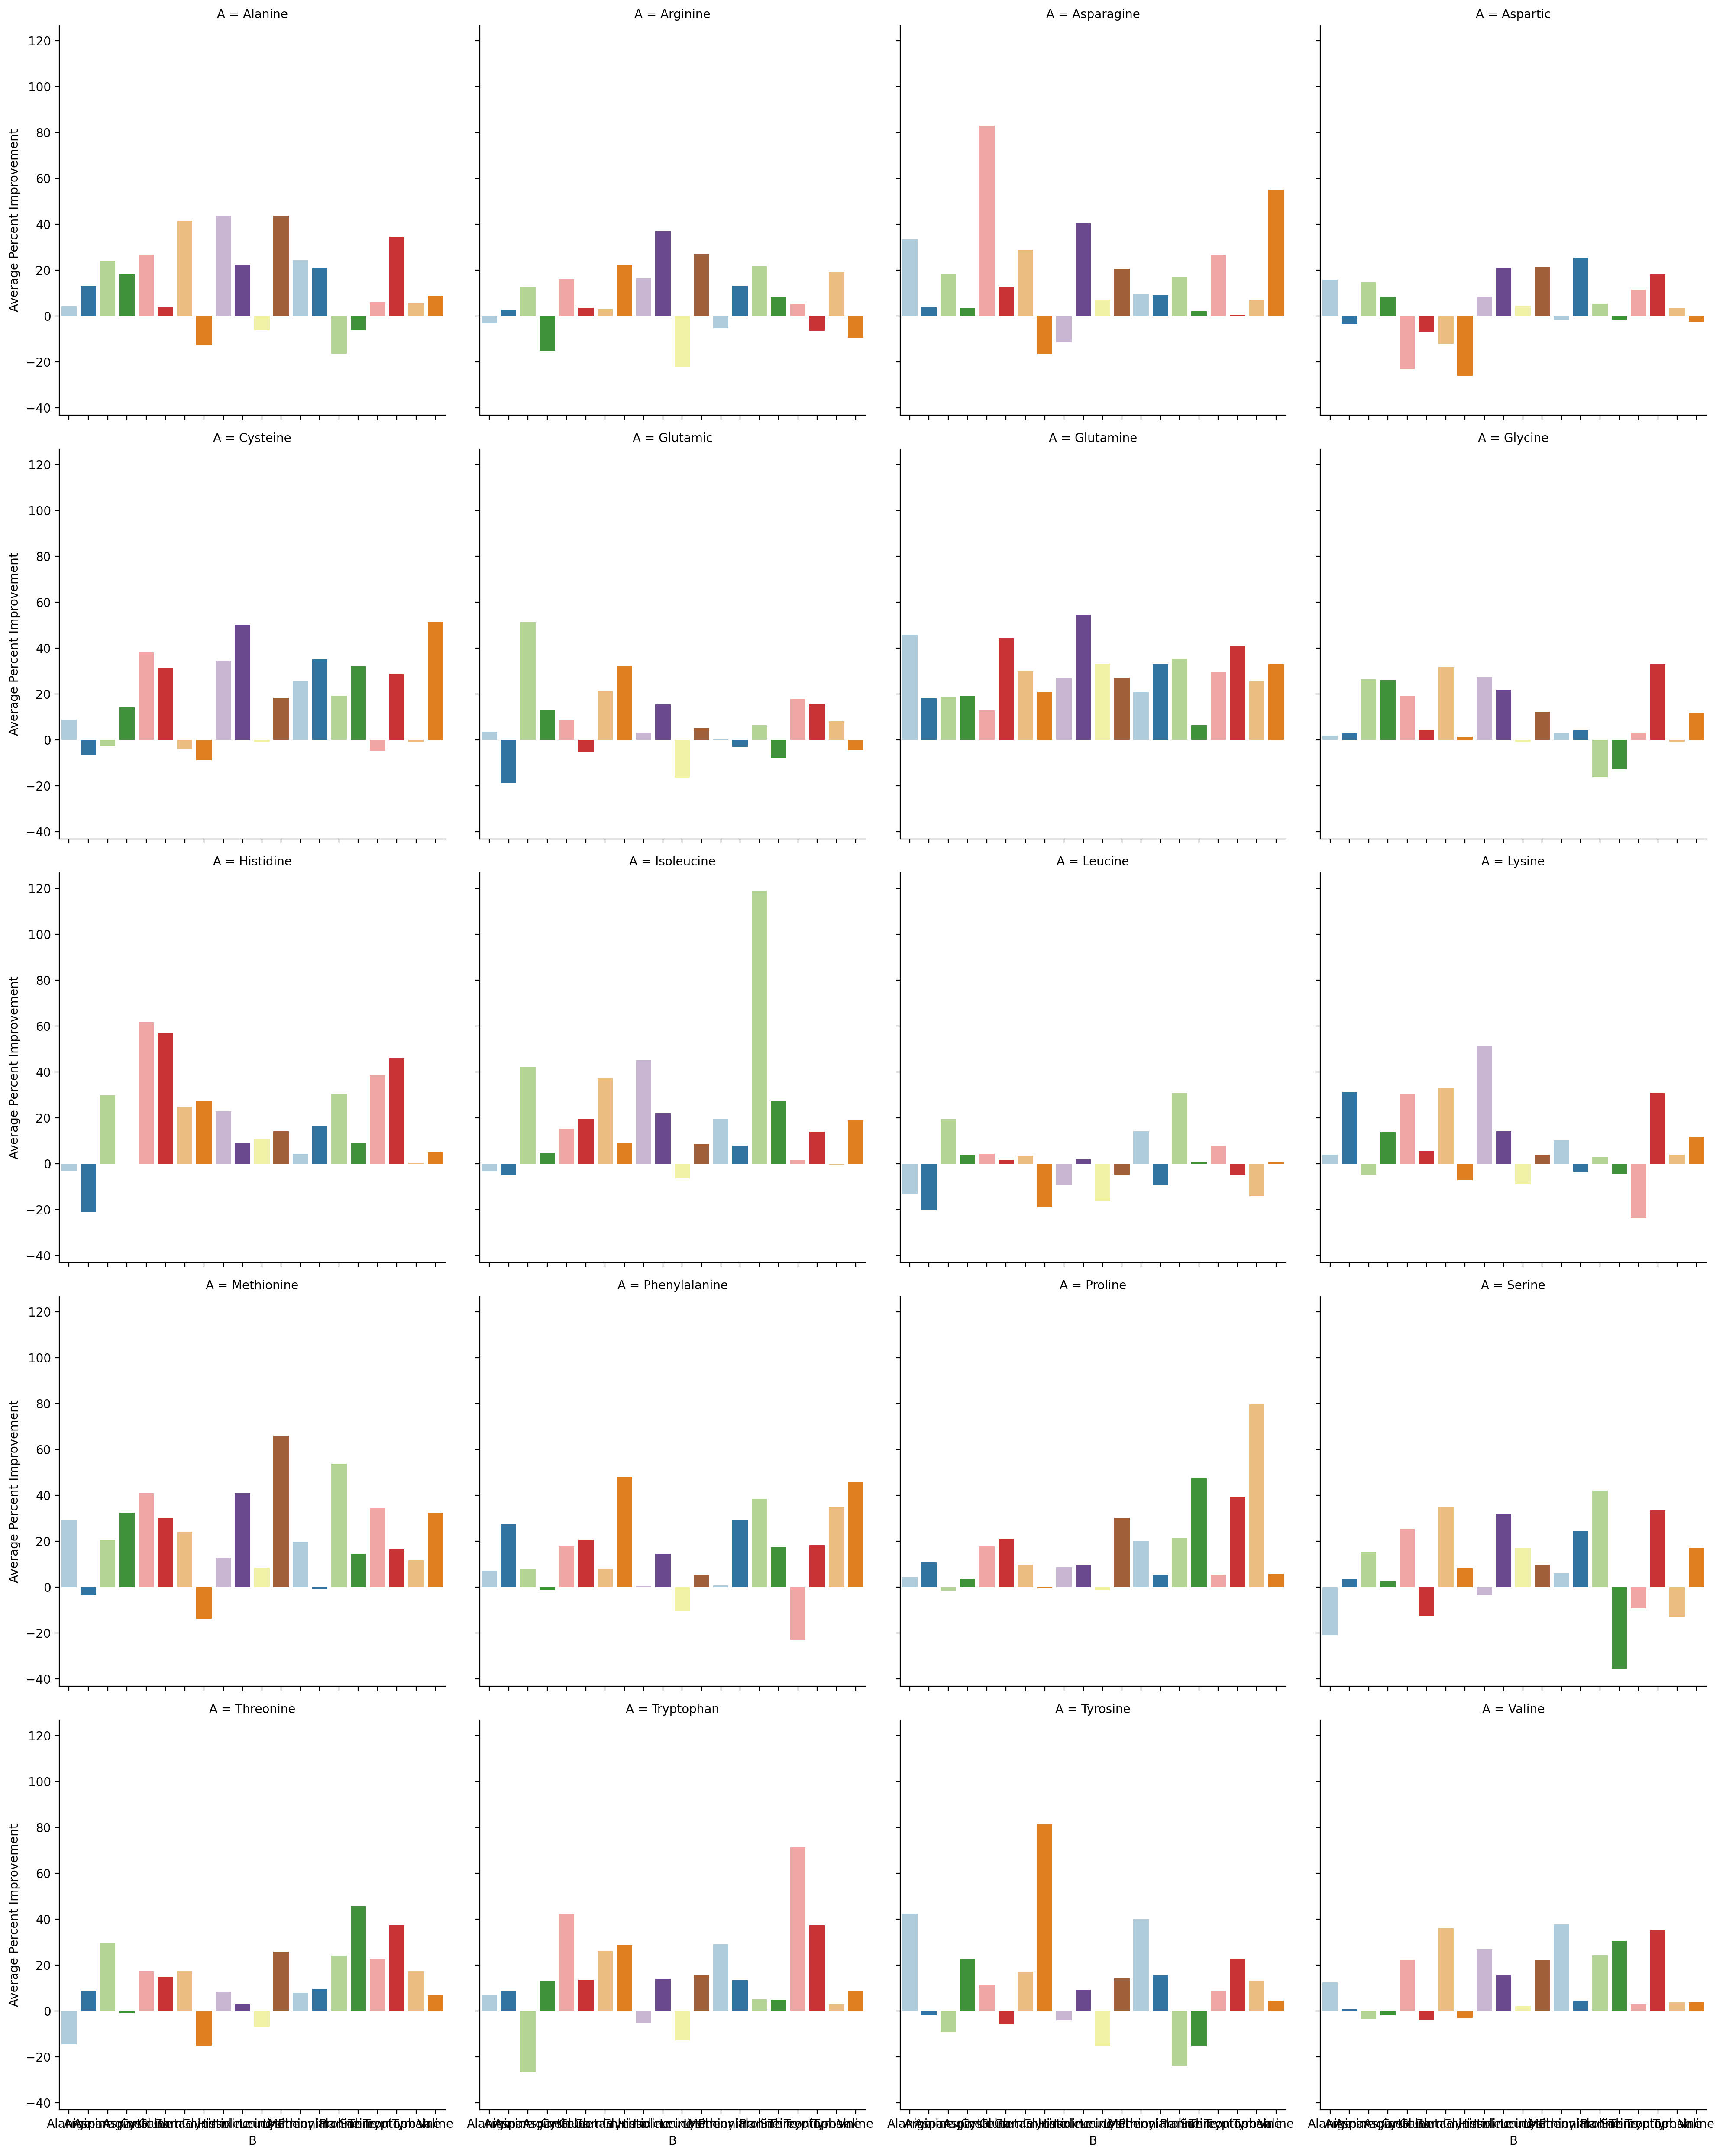

In [64]:
sns.catplot(data=pd.DataFrame(avgpercent_bars,columns=['A','B','Average Percent Improvement']),x='B',col='A',y='Average Percent Improvement',col_wrap=4,kind='bar',palette=sns.color_palette('Paired',20))

In [65]:
percent_bars=[]
for A in AA_df.index:
    for B in AA_df.index:
        percent_bars.append((A,B,100*((all_energies[A][B]-AA_df.loc[A])/AA_df.loc[A]).values[0],100*((all_energies[A][B]-AA_df.loc[B])/AA_df.loc[B]).values[0]))
        # all_energies[A][B]<AA_df.loc[A]
        # all_energies[A][B]<AA_df.loc[B]
dfpercent_bars=pd.DataFrame(percent_bars,columns=['A','B','A%','B%']).melt(id_vars=['A','B'], value_vars=['A%','B%']).rename(columns={'value':'Percent Improvement (%)'})

In [66]:
dfpercent_bars

,A,B,variable,Percent Improvement (%)
0,Alanine,Alanine,A%,4.472523
1,Alanine,Arginine,A%,39.707855
2,Alanine,Asparagine,A%,48.093062
3,Alanine,Aspartic,A%,35.934684
4,Alanine,Cysteine,A%,26.223951
...,...,...,...,...
795,Valine,Serine,B%,16.308437
796,Valine,Threonine,B%,-4.459158
797,Valine,Tryptophan,B%,32.043512
798,Valine,Tyrosine,B%,-7.260604


In [67]:
dfpercent_bars.loc[dfpercent_bars['Percent Improvement (%)'].nlargest(5).index]

,A,B,variable,Percent Improvement (%)
194,Isoleucine,Proline,A%,123.225423
444,Asparagine,Cysteine,B%,119.520531
594,Isoleucine,Proline,B%,114.821642
767,Tyrosine,Glycine,B%,106.030351
298,Proline,Tyrosine,A%,94.663929


/var/folders/px/qyhp9b8j4bb0z5wgydzgkpxw0000gn/T/ipykernel_3251/3057470797.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
/var/folders/px/qyhp9b8j4bb0z5wgydzgkpxw0000gn/T/ipykernel_3251/3057470797.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
/var/folders/px/qyhp9b8j4bb0z5wgydzgkpxw0000gn/T/ipykernel_3251/3057470797.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
/var/folders/px/qyhp9b8j4bb0z5wgydzgkpxw0000gn/T/ipykernel_3251/3057470797.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using 

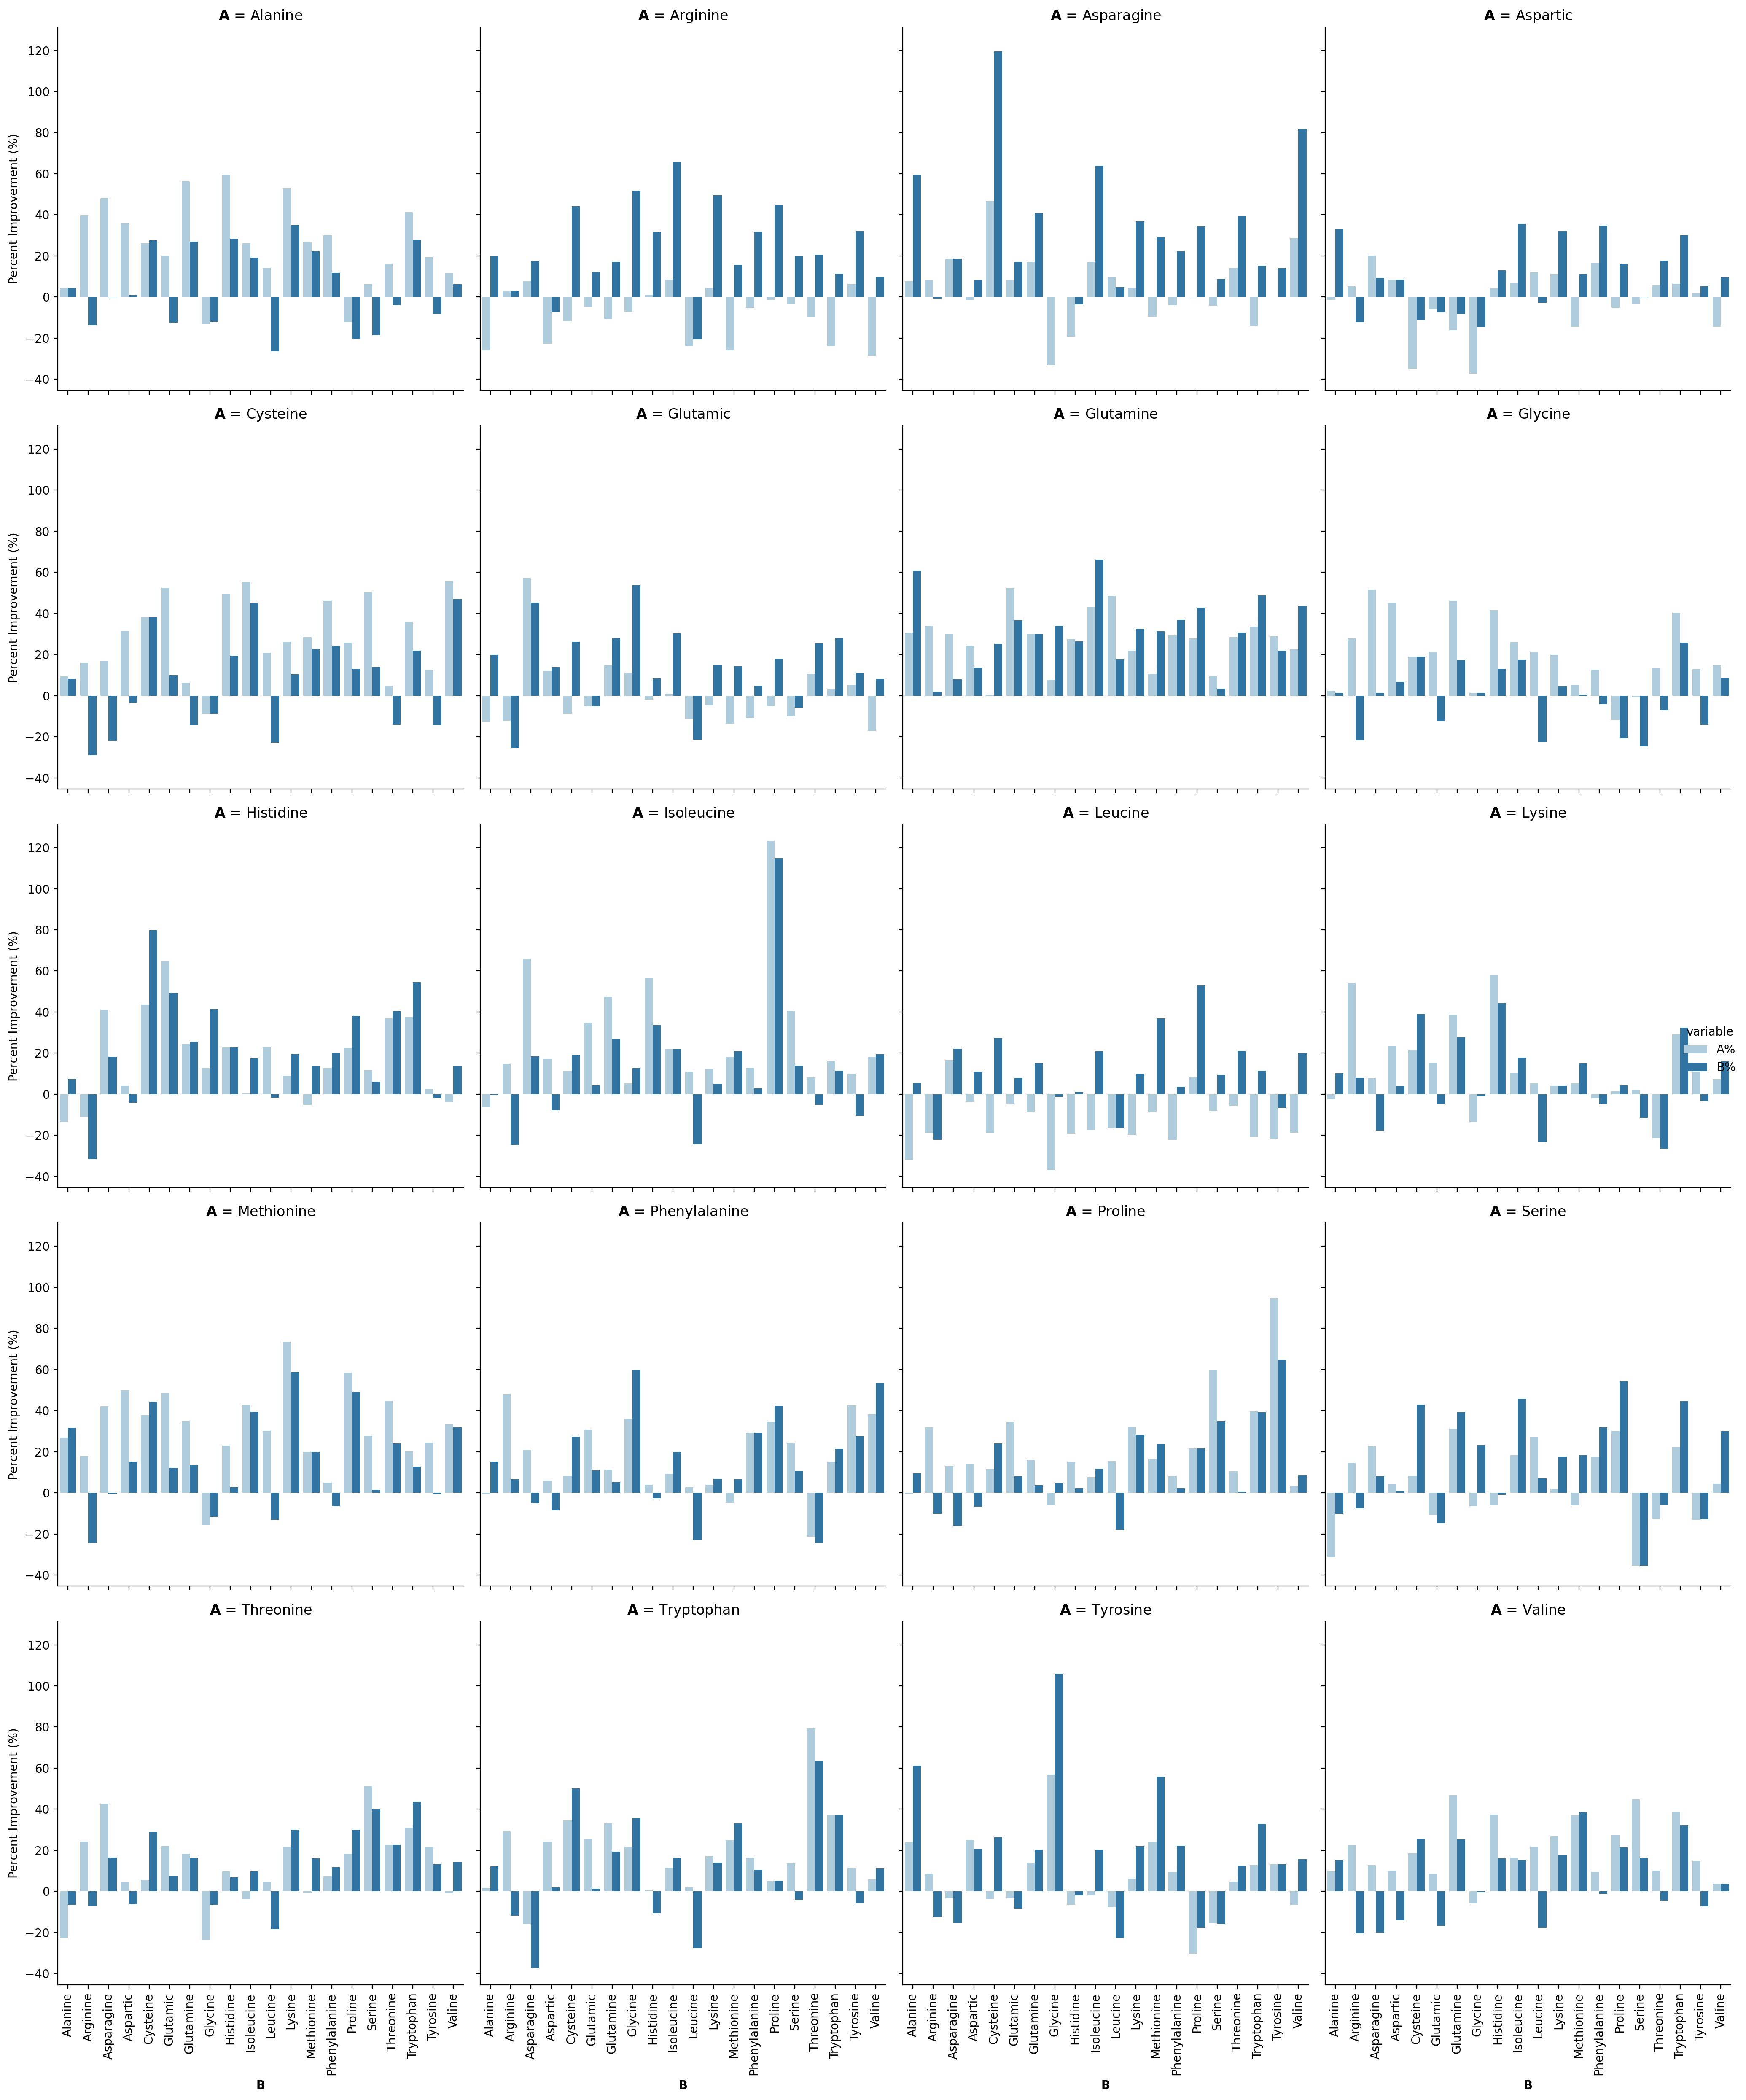

In [68]:
g=sns.catplot(data=dfpercent_bars,col='A',x='B',y='Percent Improvement (%)',hue='variable',col_wrap=4,kind='bar',palette=sns.color_palette('Paired',2))
for ax in g.axes[-4:]:
    _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
for ax in g.axes:
    ax.set_xlabel(r"$\bf{" + ax.get_xlabel()+ "}$ ")
    ax.set_title(r"$\bf{" + ax.get_title().split()[0]+ "}$ "+' '.join(ax.get_title().split()[1:]))
plt.tight_layout()
plt.savefig('percent_improvement.png',dpi=300,bbox_inches='tight')

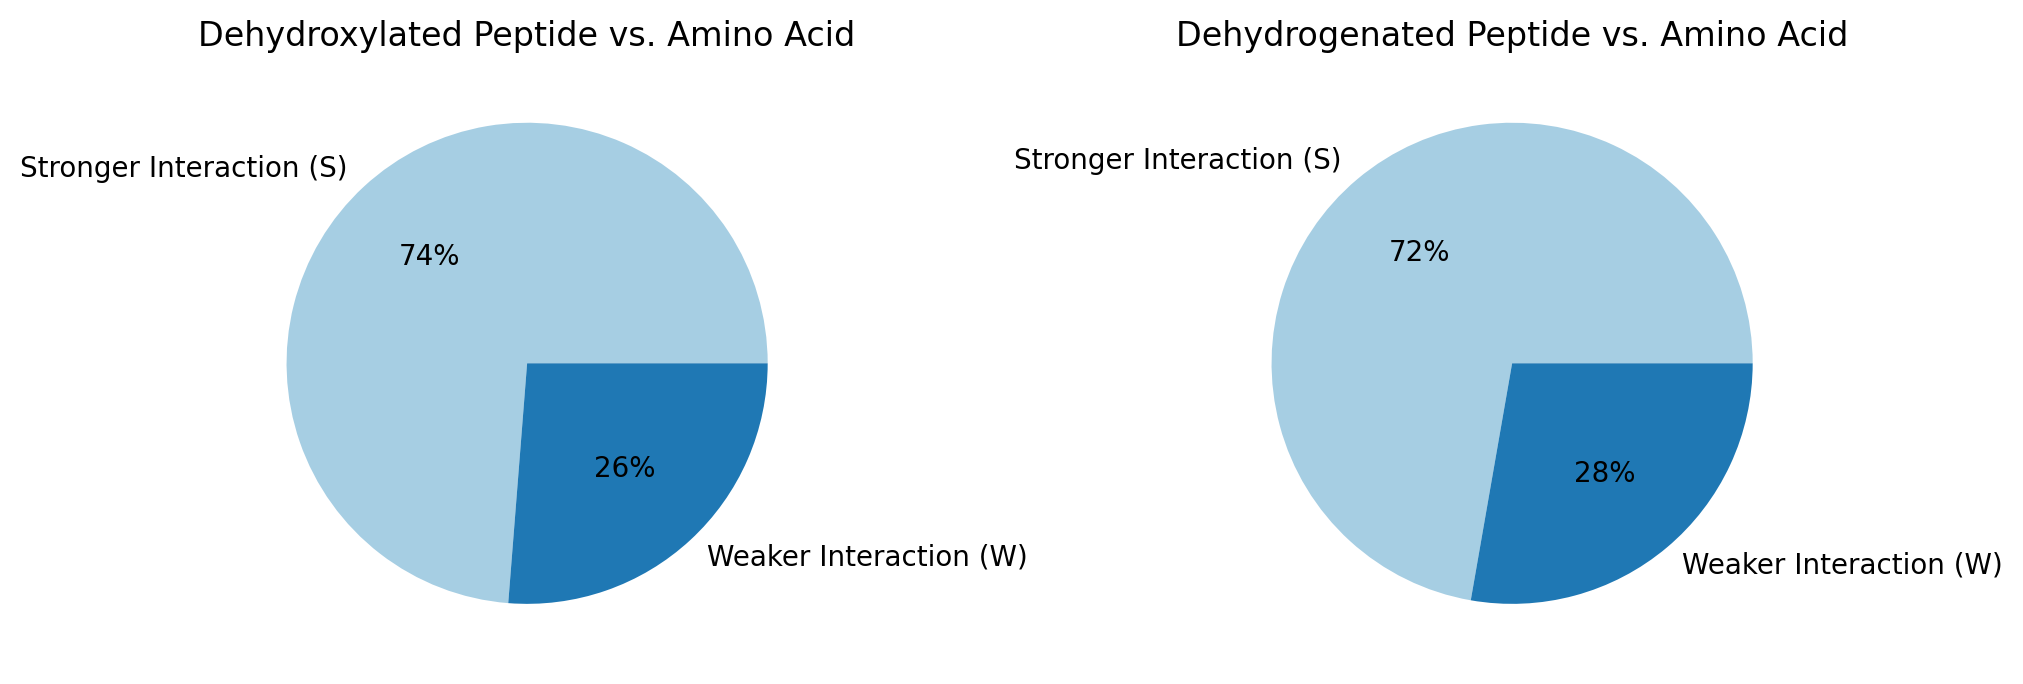

In [69]:





fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,15))


cmap=sns.color_palette('Paired',2)
ax1.pie(greaterdehydroxy_int.values, labels = ['Stronger Interaction (S)','Weaker Interaction (W)'], autopct='%.0f%%',colors=cmap)
ax1.set_title('Dehydroxylated Peptide vs. Amino Acid')


ax2.pie(greaterdehydro_int.values, labels = ['Stronger Interaction (S)','Weaker Interaction (W)'], autopct='%.0f%%',colors=cmap)
ax2.set_title('Dehydrogenated Peptide vs. Amino Acid')
plt.tight_layout()
plt.savefig('interaction_compare.png',dpi=300,bbox_inches='tight')
plt.show()





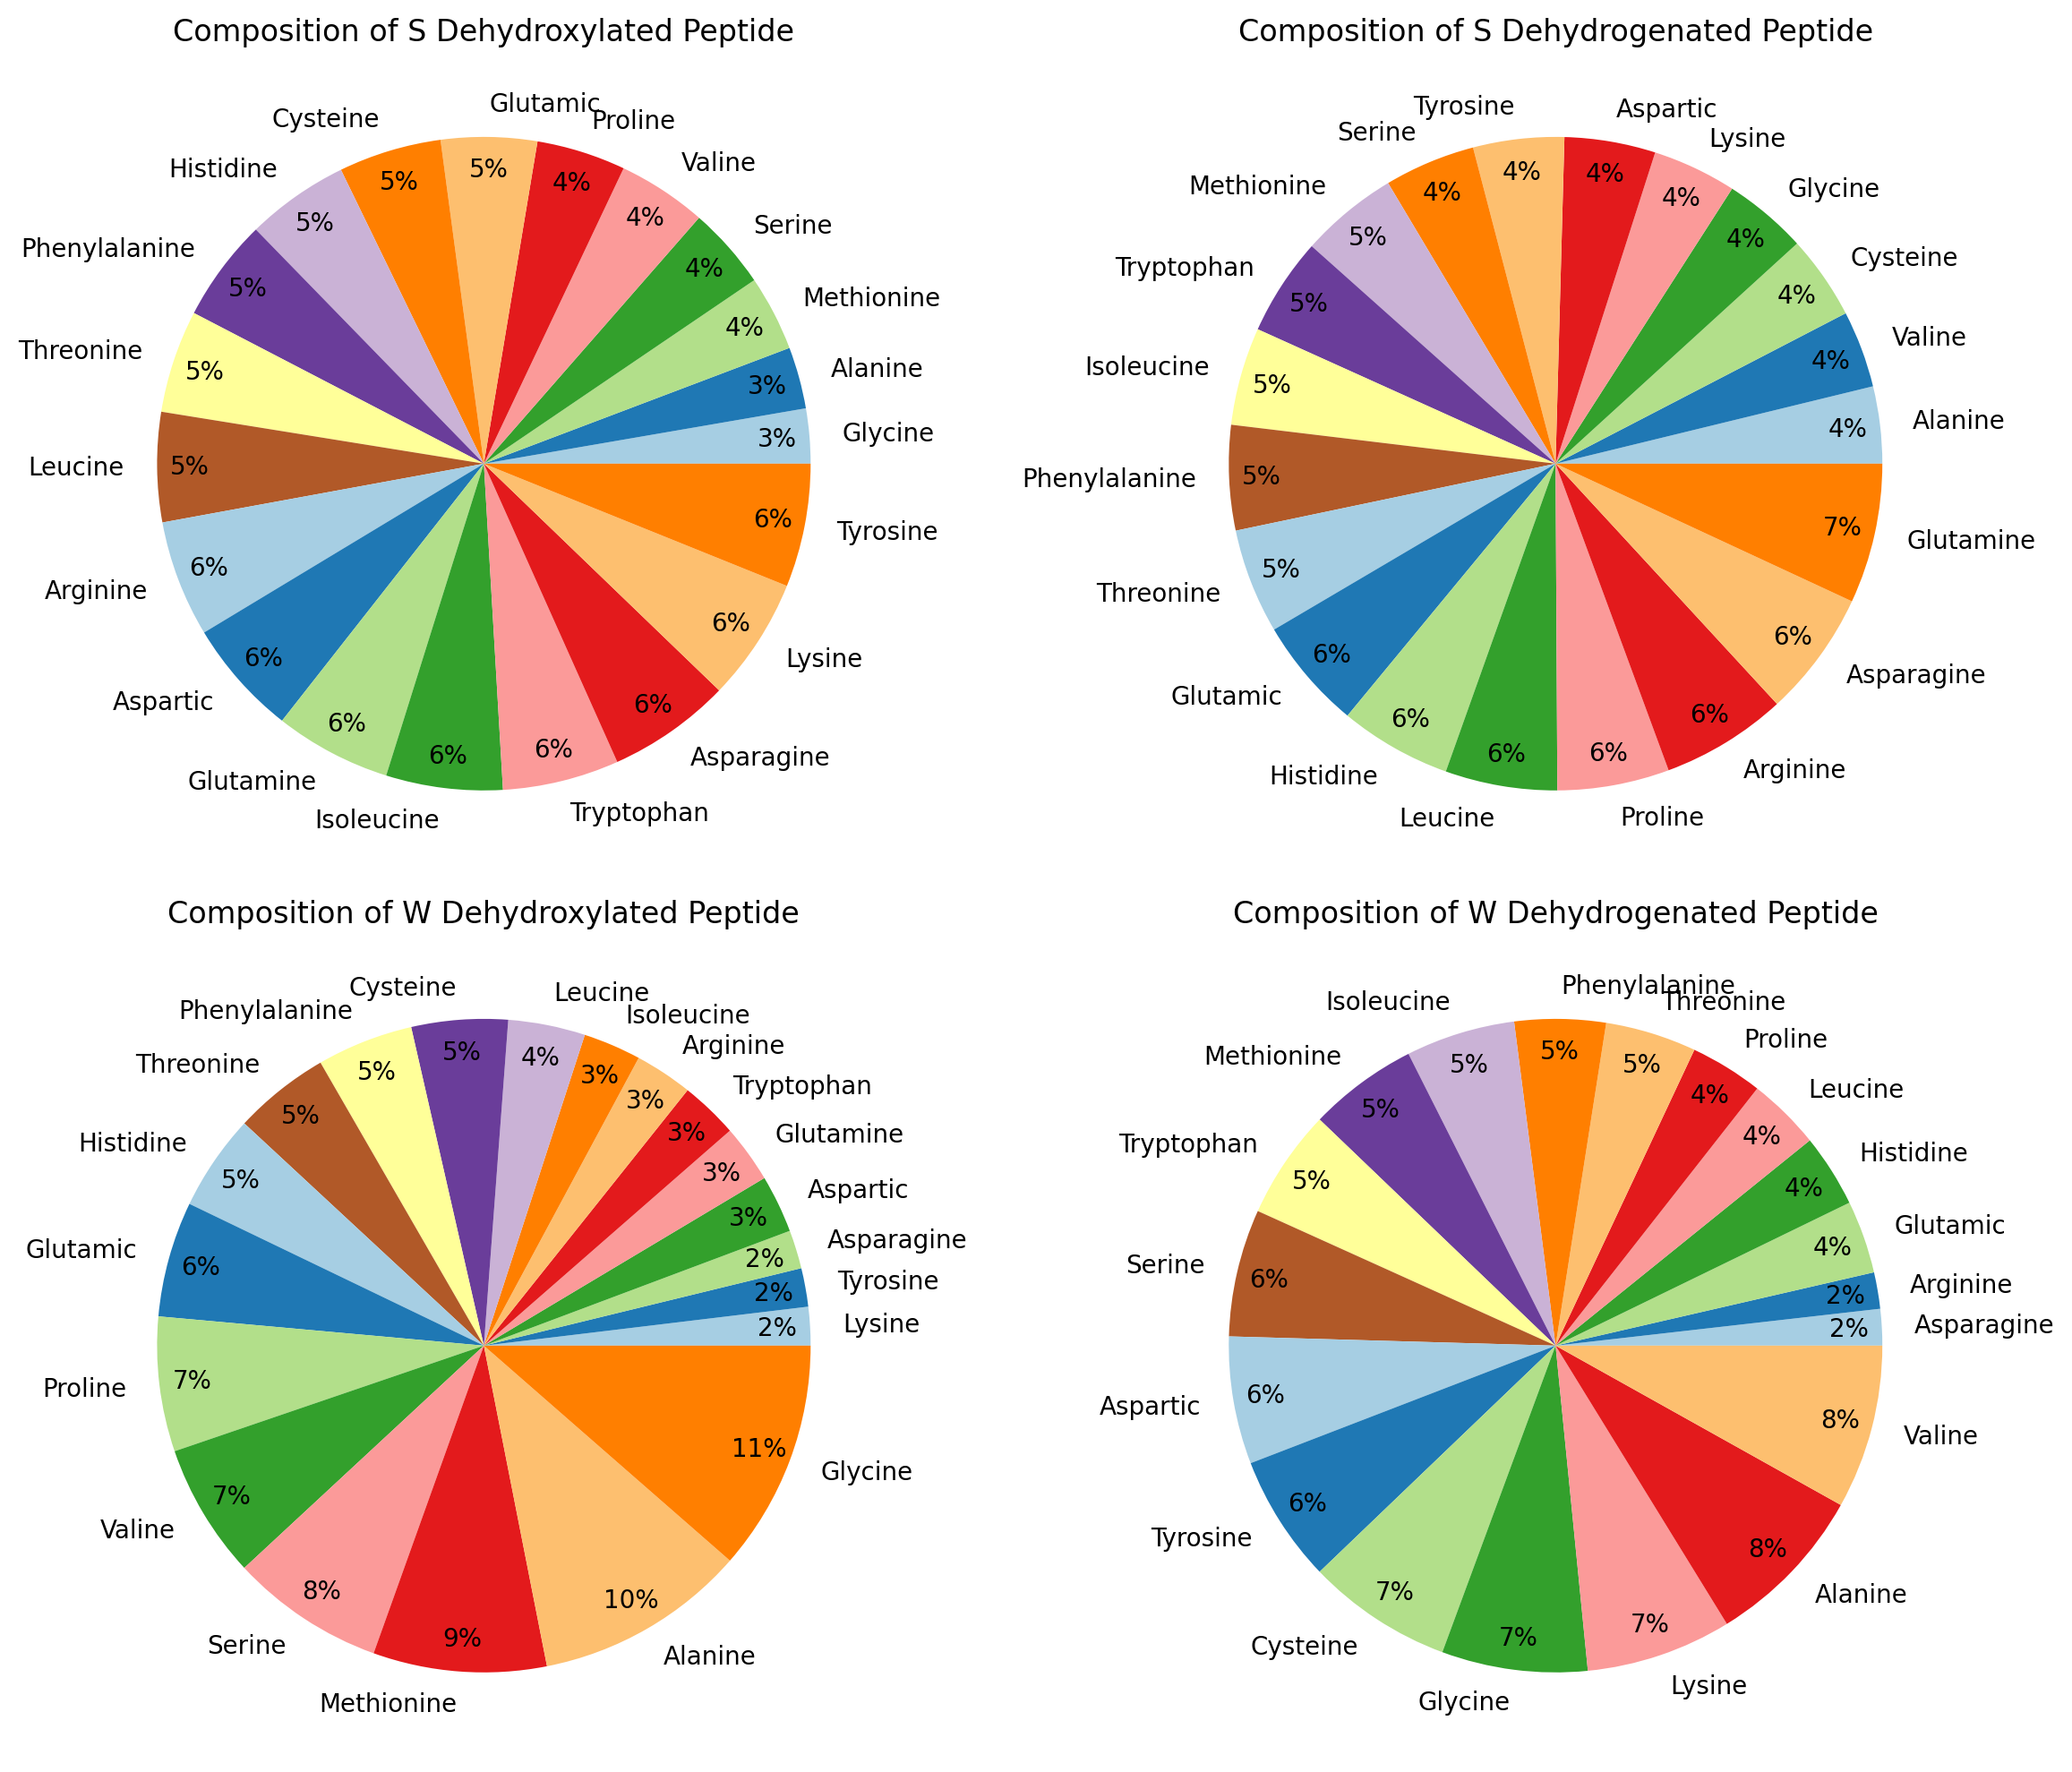

In [70]:





fig,((ax1,ax2),(ax3,ax4))=plt.subplots(2,2,figsize=(12,10))


cmap=sns.color_palette('Paired',2)




gtIE_dehydroxy=[]
for i in AA_df.index:
    gtIE_dehydroxy.append(list(all_energies[i][AA_df.loc[i].values[0]>all_energies[i]].index))
gtIE_dehydroxy_arr=np.array(sorted(Counter(sum(gtIE_dehydroxy,[])).items(),key=lambda x: x[1]))

mincmap=sns.color_palette('Paired',len(gtIE_dehydroxy_arr))
ax1.pie(gtIE_dehydroxy_arr[:,1].astype(int), labels = gtIE_dehydroxy_arr[:,0], autopct='%.0f%%',colors=mincmap, pctdistance=0.9)
ax1.set_title('Composition of S Dehydroxylated Peptide')



ltIE_dehydroxy=[]
for i in AA_df.index:
    ltIE_dehydroxy.append(list(all_energies[i][AA_df.loc[i].values[0]<all_energies[i]].index))
ltIE_dehydroxy_arr=np.array(sorted(Counter(sum(ltIE_dehydroxy,[])).items(),key=lambda x: x[1]))

mincmap=sns.color_palette('Paired',len(ltIE_dehydroxy_arr))
ax3.pie(ltIE_dehydroxy_arr[:,1].astype(int), labels = ltIE_dehydroxy_arr[:,0], autopct='%.0f%%',colors=mincmap, pctdistance=0.9)
ax3.set_title('Composition of W Dehydroxylated Peptide')

gtIE_dehydrogen=[]
for i in AA_df.index:
    gtIE_dehydrogen.append(list(all_energies.T[i][AA_df.loc[i].values[0]>all_energies.T[i]].index))
gtIE_dehydrogen_arr=np.array(sorted(Counter(sum(gtIE_dehydrogen,[])).items(),key=lambda x: x[1]))

mincmap=sns.color_palette('Paired',len(gtIE_dehydrogen_arr))
ax2.pie(gtIE_dehydrogen_arr[:,1].astype(int), labels = gtIE_dehydrogen_arr[:,0], autopct='%.0f%%',colors=mincmap, pctdistance=0.9)
ax2.set_title('Composition of S Dehydrogenated Peptide')


ltIE_dehydrogen=[]
for i in AA_df.index:
    ltIE_dehydrogen.append(list(all_energies.T[i][AA_df.loc[i].values[0]<all_energies.T[i]].index))
ltIE_dehydrogen_arr=np.array(sorted(Counter(sum(ltIE_dehydrogen,[])).items(),key=lambda x: x[1]))

mincmap=sns.color_palette('Paired',len(ltIE_dehydrogen_arr))
ax4.pie(ltIE_dehydrogen_arr[:,1].astype(int), labels = ltIE_dehydrogen_arr[:,0], autopct='%.0f%%',colors=mincmap, pctdistance=0.9)
ax4.set_title('Composition of W Dehydrogenated Peptide')

plt.tight_layout()

plt.savefig('SI_interaction_compare.png',dpi=300,bbox_inches='tight')
plt.show()





In [71]:
pd.concat([pd.DataFrame.from_dict(dict(Counter(sum(ltIE_dehydroxy,[]))),orient='index'),pd.DataFrame.from_dict(dict(Counter(sum(ltIE_dehydrogen,[]))),orient='index')],axis=1).sum(axis=1).sort_values()

Glutamine         3.0
Asparagine        4.0
Arginine          5.0
Leucine           8.0
Isoleucine        9.0
Histidine         9.0
Tryptophan        9.0
Tyrosine          9.0
Lysine           10.0
Threonine        10.0
Phenylalanine    10.0
Glutamic         10.0
Aspartic         10.0
Proline          11.0
Cysteine         13.0
Methionine       15.0
Serine           15.0
Valine           16.0
Alanine          20.0
Glycine          20.0
dtype: float64

In [72]:
pd.concat([pd.DataFrame.from_dict(dict(Counter(sum(gtIE_dehydroxy,[]))),orient='index'),pd.DataFrame.from_dict(dict(Counter(sum(gtIE_dehydrogen,[]))),orient='index')],axis=1).sum(axis=1).sort_values()




Alanine          20
Glycine          20
Valine           24
Methionine       25
Serine           25
Cysteine         27
Proline          29
Lysine           30
Aspartic         30
Glutamic         30
Phenylalanine    30
Threonine        30
Histidine        31
Isoleucine       31
Tyrosine         31
Tryptophan       31
Leucine          32
Arginine         35
Asparagine       36
Glutamine        37
dtype: int64

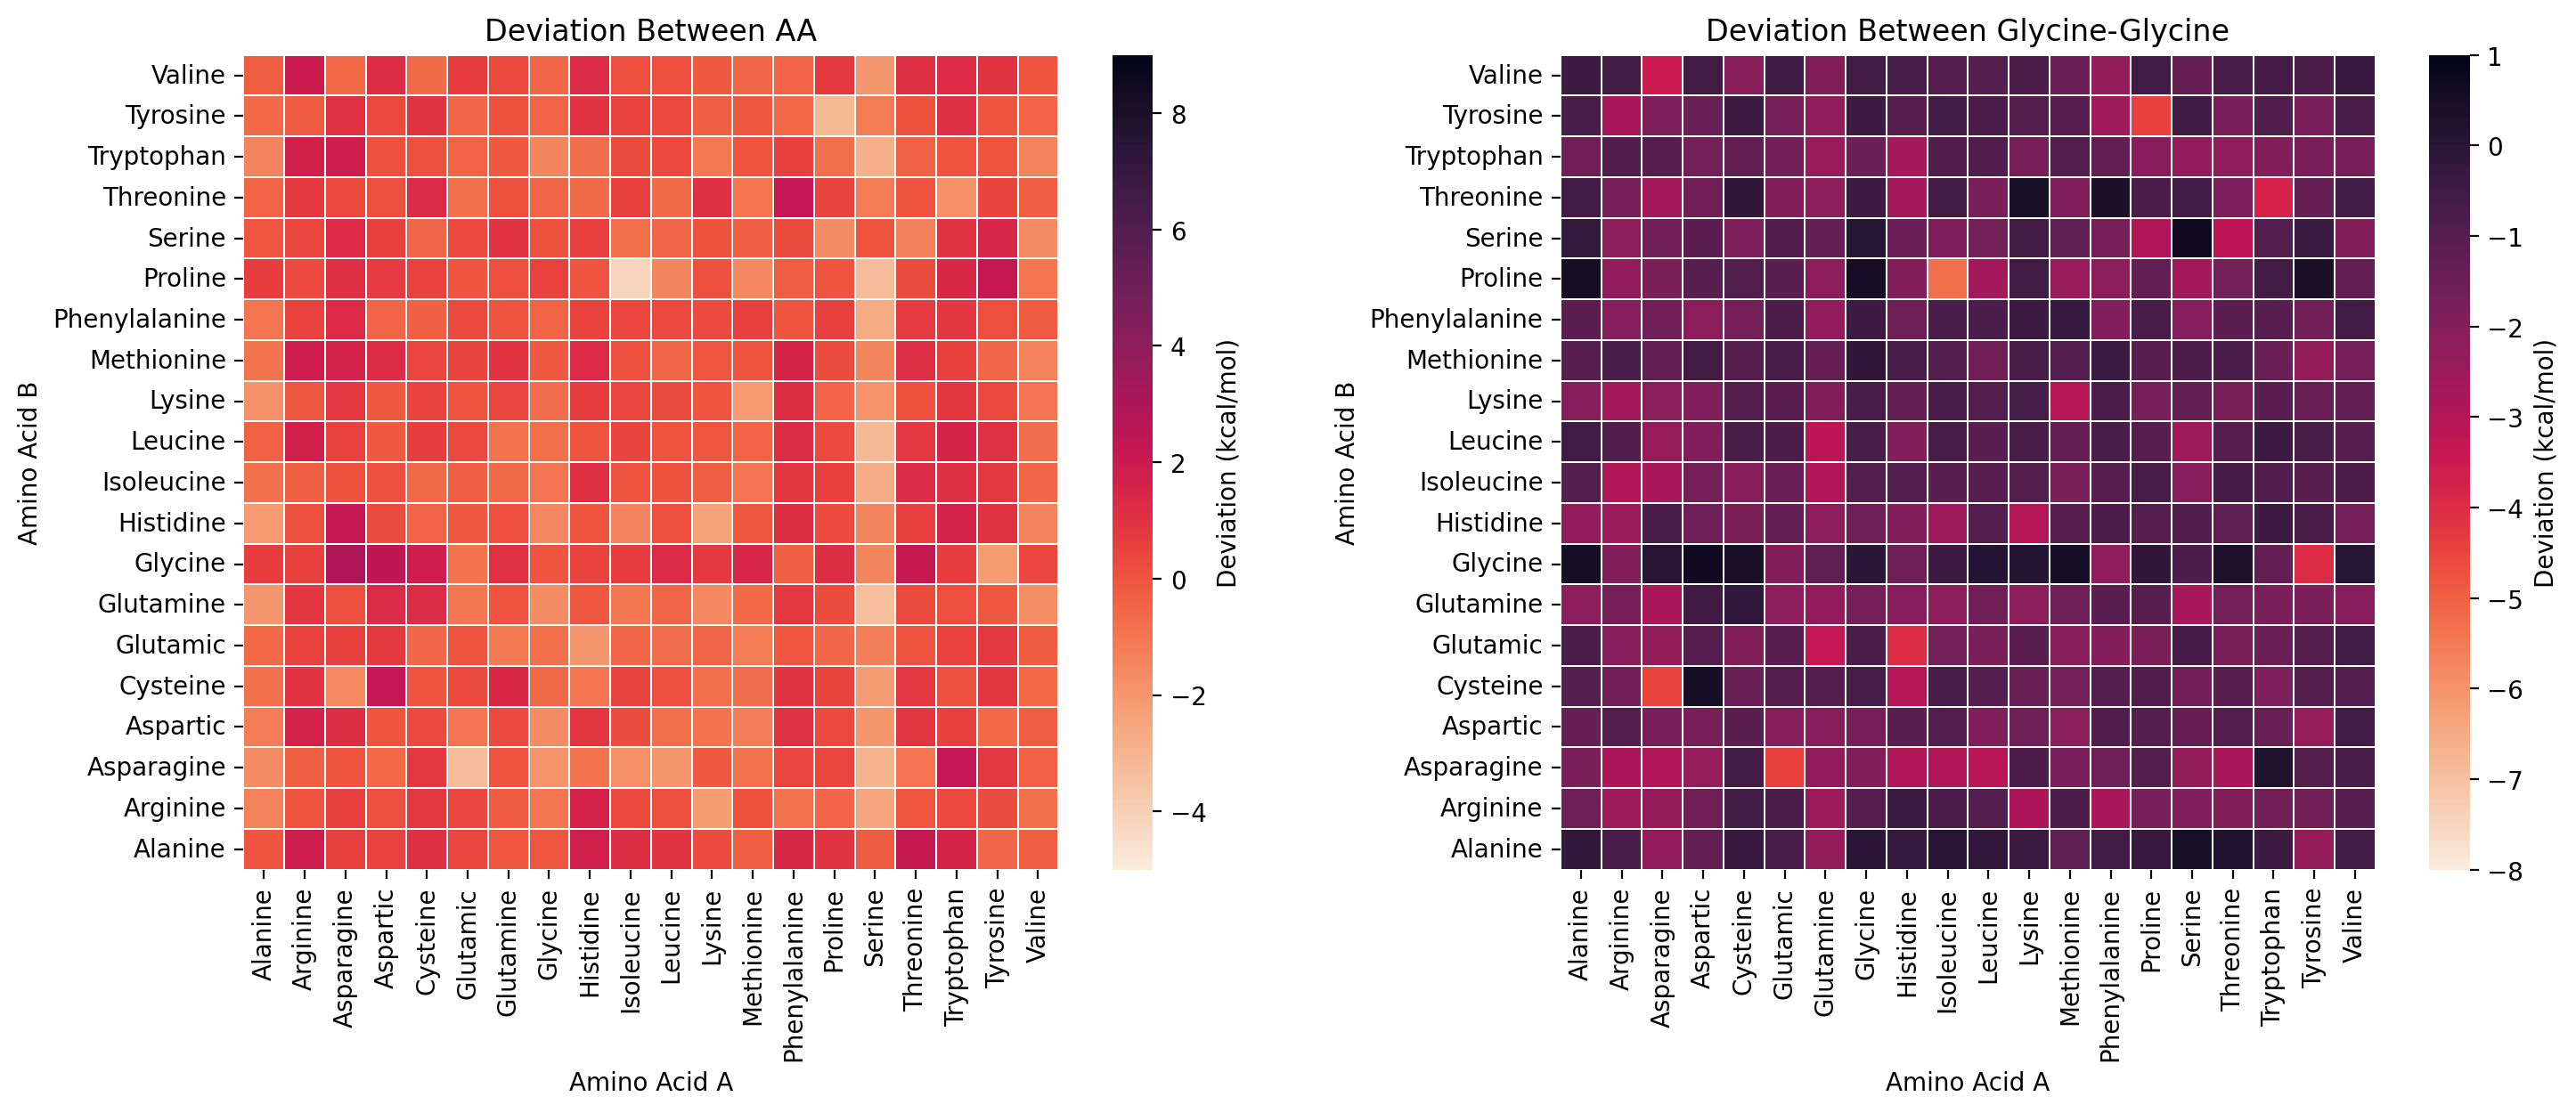

In [73]:
from matplotlib.colors import LinearSegmentedColormap

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,6))
cmap = sns.cm.rocket_r
# cmap = LinearSegmentedColormap.from_list('', np.vstack([sns.color_palette('rocket'),sns.color_palette('rocket_r')]))
sns.heatmap(data=IE_df.astype(float),ax=ax1,cmap=cmap, linewidth=.01,cbar_kws={'label': 'Deviation (kcal/mol)'}, vmin=-5, vmax=9,square=True)
ax1.set_title('Deviation Between AA')
ax1.set_xlabel('Amino Acid A')
ax1.set_ylabel('Amino Acid B')
ax1.invert_yaxis()

# cmap = LinearSegmentedColormap.from_list('', np.vstack([sns.color_palette('rocket',8),sns.color_palette('rocket_r',3)]))
sns.heatmap(data=glygly_df.astype(float),ax=ax2,cmap=cmap, linewidth=.01,cbar_kws={'label': 'Deviation (kcal/mol)'}, vmin=-8, vmax=1,square=True)
ax2.set_title('Deviation Between Glycine-Glycine')
ax2.set_xlabel('Amino Acid A')
ax2.set_ylabel('Amino Acid B')
ax2.invert_yaxis()
plt.tight_layout()
# plt.savefig(rdeviations.png',dpi=300,bbox_inches='tight')
plt.show()

In [74]:
site_df=df[sorted(sitelist)+['Interaction_Energy']].sort_values(by='Interaction_Energy')

In [75]:
site_df[site_df==0]=np.nan

In [76]:
len(sitelist)

8

In [77]:
[(i+1)%2 for i in range(8)]

[1, 0, 1, 0, 1, 0, 1, 0]

In [78]:
interdict_conv={'A_carboxy':'A Carboxyl', 'A_amine':'A Secondary Amine', 'A_link':'A Linking Hydrogen', 'A_side':'A Side-Chain','B_carboxy':'B Carboxylic Acid', 'B_amine':'B Primary Amine', 'B_link':'B Linking Hydrogen', 'B_side':'B Side-Chain'}

In [79]:


for i in sorted(set([i.strip('A_').strip('_B') for i in sitelist])):
    print(i)
    print(site_df.loc[site_df[f'A_{i}'].dropna().index]['Interaction_Energy'].describe())
    print(site_df.loc[site_df[f'B_{i}'].dropna().index]['Interaction_Energy'].describe())
    print()

amine
count    69.000000
mean     -5.473535
std       0.918054
min      -9.129920
25%      -6.032490
50%      -5.401066
75%      -4.718104
max      -3.258298
Name: Interaction_Energy, dtype: float64
count    94.000000
mean     -5.136808
std       0.884591
min      -8.385684
25%      -5.782293
50%      -4.886359
75%      -4.556084
max      -3.774012
Name: Interaction_Energy, dtype: float64

carboxy
count    210.000000
mean      -5.131966
std        0.859261
min       -8.313269
25%       -5.716147
50%       -4.939436
75%       -4.578118
max       -3.255937
Name: Interaction_Energy, dtype: float64
count    144.000000
mean      -5.273975
std        0.865053
min       -9.129920
25%       -5.799136
50%       -5.184471
75%       -4.679525
max       -3.569942
Name: Interaction_Energy, dtype: float64

link
count    17.000000
mean     -5.534842
std       0.920098
min      -8.273217
25%      -5.800714
50%      -5.552007
75%      -5.164778
max      -3.792406
Name: Interaction_Energy, dtype: float6

In [80]:
site_df.loc[site_df['A_amine'].dropna().index]['Interaction_Energy'].describe()

count    69.000000
mean     -5.473535
std       0.918054
min      -9.129920
25%      -6.032490
50%      -5.401066
75%      -4.718104
max      -3.258298
Name: Interaction_Energy, dtype: float64

In [81]:
site_df.loc[site_df['B_amine'].dropna().index]['Interaction_Energy'].describe()

count    94.000000
mean     -5.136808
std       0.884591
min      -8.385684
25%      -5.782293
50%      -4.886359
75%      -4.556084
max      -3.774012
Name: Interaction_Energy, dtype: float64

In [82]:
site_df

,A_amine,A_carboxy,A_link,A_side,B_amine,B_carboxy,B_link,B_side,Interaction_Energy
Isoleucine-Proline,1.0,NaN,NaN,NaN,NaN,1.0,NaN,1.0,-9.129920
Asparagine-Cysteine,NaN,NaN,NaN,2.0,1.0,NaN,NaN,NaN,-8.385684
Glutamic-Asparagine,NaN,2.0,NaN,NaN,NaN,NaN,NaN,1.0,-8.313269
Proline-Tyrosine,NaN,NaN,1.0,1.0,NaN,NaN,NaN,1.0,-8.273217
Histidine-Glutamic,NaN,NaN,NaN,1.0,NaN,2.0,NaN,NaN,-7.889352
...,...,...,...,...,...,...,...,...,...
Methionine-Glycine,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,-3.374341
Glycine-Proline,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,-3.369284
Alanine-Glycine,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,-3.359185
Aspartic-Glycine,1.0,NaN,NaN,2.0,NaN,NaN,NaN,NaN,-3.258298


In [83]:
sitelist

['A_carboxy',
 'A_amine',
 'B_carboxy',
 'B_amine',
 'A_link',
 'B_link',
 'A_side',
 'B_side']

In [84]:
pd.concat([site_df[site_df[i].isna()==False]['Interaction_Energy'].describe().rename(i) for i in sitelist],axis=1).to_excel('interaction_site_dist.xlsx')

In [85]:
site_df[site_df['A_amine'].isna()==False]['Interaction_Energy'].describe().round(2).loc['mean']

-5.47

In [86]:
for sl in sorted(set([i.split('_')[1] for i in sitelist])):
    print("A_"+sl,site_df[site_df["A_"+sl].isna()==False]['Interaction_Energy'].describe().round(2).loc['mean'])
    print("B_"+sl,site_df[site_df["B_"+sl].isna()==False]['Interaction_Energy'].describe().round(2).loc['mean'])
    print()

A_amine -5.47
B_amine -5.14

A_carboxy -5.13
B_carboxy -5.27

A_link -5.53
B_link -5.1

A_side -5.51
B_side -5.33



In [106]:
site_df.loc['Arginine-Lysine']

A_amine                    NaN
A_carboxy                  NaN
A_link                     NaN
A_side                3.000000
B_amine                    NaN
B_carboxy                  NaN
B_link                     NaN
B_side                     NaN
Interaction_Energy   -6.531635
Name: Arginine-Lysine, dtype: float64

In [87]:
site_df.sort_values(by='Interaction_Energy').nsmallest(10,columns=['Interaction_Energy'])

,A_amine,A_carboxy,A_link,A_side,B_amine,B_carboxy,B_link,B_side,Interaction_Energy
Isoleucine-Proline,1.0,NaN,NaN,NaN,NaN,1.0,NaN,1.0,-9.129920
Asparagine-Cysteine,NaN,NaN,NaN,2.0,1.0,NaN,NaN,NaN,-8.385684
Glutamic-Asparagine,NaN,2.0,NaN,NaN,NaN,NaN,NaN,1.0,-8.313269
Proline-Tyrosine,NaN,NaN,1.0,1.0,NaN,NaN,NaN,1.0,-8.273217
Histidine-Glutamic,NaN,NaN,NaN,1.0,NaN,2.0,NaN,NaN,-7.889352
Tyrosine-Glycine,1.0,NaN,NaN,1.0,NaN,1.0,NaN,NaN,-7.870359
Tryptophan-Threonine,NaN,2.0,NaN,NaN,NaN,NaN,NaN,1.0,-7.636904
Asparagine-Valine,NaN,NaN,NaN,2.0,1.0,NaN,NaN,NaN,-7.359317
Glutamine-Glutamic,NaN,2.0,NaN,NaN,NaN,NaN,NaN,1.0,-7.228973
Threonine-Serine,NaN,2.0,NaN,NaN,NaN,NaN,NaN,1.0,-7.062454


In [88]:
site_df.sum().drop('Interaction_Energy').sort_values()

A_link        17.0
B_link        43.0
A_amine       75.0
B_amine      111.0
A_side       166.0
B_side       199.0
B_carboxy    244.0
A_carboxy    345.0
dtype: float64

In [89]:
site_df.sum().loc[['A_carboxy','B_carboxy']]

A_carboxy    345.0
B_carboxy    244.0
dtype: float64

In [90]:
site_df.sum().loc[['A_side','B_side']].sum()

365.0

In [91]:
site_df.sum().loc[['A_amine','B_amine']].sum()

186.0

In [92]:
site_df.sum().loc['B_side']

199.0

In [93]:
site_df.sum().loc['A_side']

166.0

In [94]:
site_df.sum().loc[['A_carboxy','B_carboxy']].sum()

589.0

##### Counter(site_df['A_side'].dropna())

/var/folders/px/qyhp9b8j4bb0z5wgydzgkpxw0000gn/T/ipykernel_3251/319351409.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=site_df,x=i,y='Interaction_Energy',ax=ax[0,idx%4],palette=sns.color_palette('Paired',3))
/var/folders/px/qyhp9b8j4bb0z5wgydzgkpxw0000gn/T/ipykernel_3251/319351409.py:7: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.boxplot(data=site_df,x=i,y='Interaction_Energy',ax=ax[0,idx%4],palette=sns.color_palette('Paired',3))
/var/folders/px/qyhp9b8j4bb0z5wgydzgkpxw0000gn/T/ipykernel_3251/319351409.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=site_df,x=i,y='Interaction_Energy',ax=ax[0,idx%4],palette=sns.col

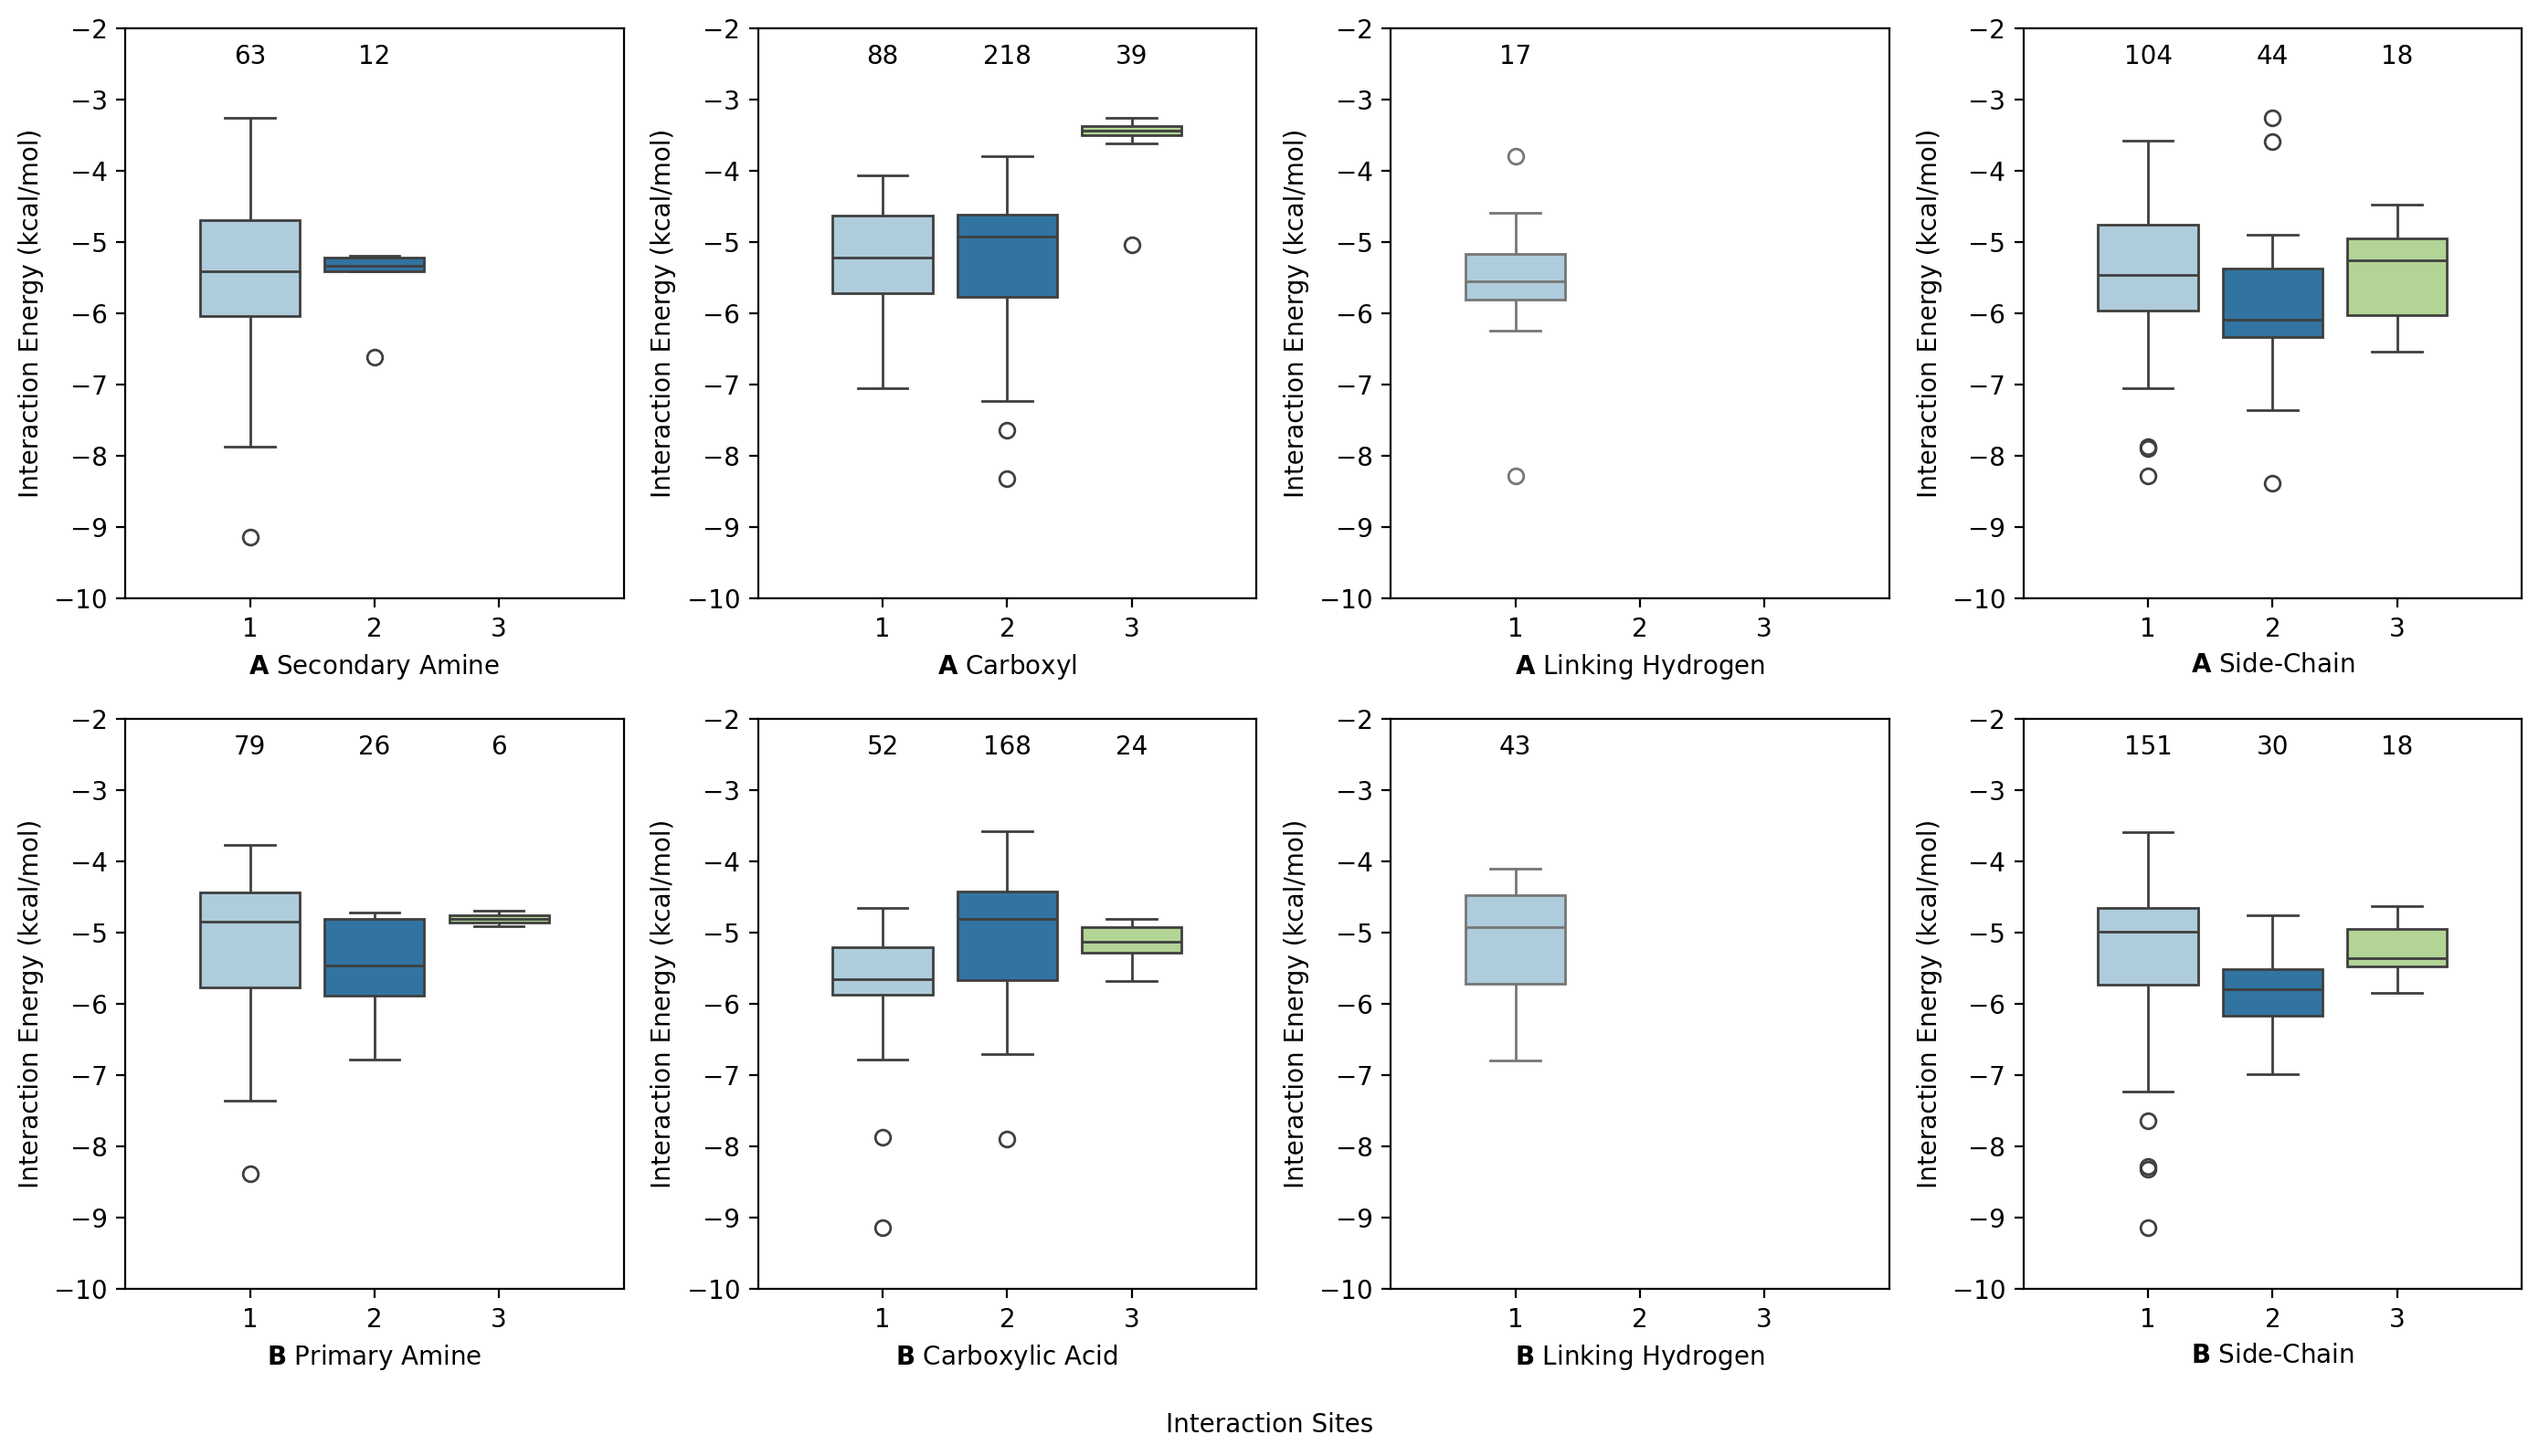

In [95]:
bardict=dict(zip(['amine', 'carboxy', 'link', 'side'],['Amine','Carboxy','Linker Hydrogen', 'Side']))
# fig,ax=plt.subplots(3,len(sitelist)//2,figsize=(15,10))
fig,ax=plt.subplots(2,len(sitelist)//2,figsize=(14,8))
for idx,i in enumerate(sorted(sitelist)):
    
    if idx<=3:
        sns.boxplot(data=site_df,x=i,y='Interaction_Energy',ax=ax[0,idx%4],palette=sns.color_palette('Paired',3))
        for k in np.arange(1,4):
            sitecnt=int(site_df[site_df[i]==k][i].sum())
            if sitecnt!=0:
                ax[0,idx%4].text(k-1,-2.5,sitecnt,horizontalalignment='center')

        ax[0,idx%4].set_xticks([0,1,2])
        ax[0,idx%4].set_xticklabels([1,2,3])
        ax[0,idx%4].set_xlabel(r"$\bf{" + interdict_conv[i].split()[0]+ "}$ "+' '.join(interdict_conv[i].split()[1:]))
        ax[0,idx%4].set_ylim(-10,-2)
        ax[0,idx%4].set_xlim(-1,3)
        ax[0,idx%4].set_ylabel('Interaction Energy (kcal/mol)')
    else:
        sns.boxplot(data=site_df,x=i,y='Interaction_Energy',ax=ax[1,idx%4],palette=sns.color_palette('Paired',3))
        for k in np.arange(1,4):
            sitecnt=int(site_df[site_df[i]==k][i].sum())
            if sitecnt!=0:
                ax[1,idx%4].text(k-1,-2.5,sitecnt,horizontalalignment='center')
        ax[1,idx%4].set_xticks([0,1,2])
        ax[1,idx%4].set_xticklabels([1,2,3])
        ax[1,idx%4].set_xlabel(r"$\bf{" + interdict_conv[i].split()[0]+ "}$ "+' '.join(interdict_conv[i].split()[1:]))
        ax[1,idx%4].set_ylim(-10,-2)
        ax[1,idx%4].set_xlim(-1,3)        
        ax[1,idx%4].set_ylabel('Interaction Energy (kcal/mol)')

    
# for idxx,j in enumerate(sorted(set([i.split('_')[1] for i in sitelist]))):
#     melted=pd.concat([site_df[f'A_{j}'].value_counts(),site_df[f'B_{j}'].value_counts()],axis=1).reset_index().melt(id_vars='index')
#     ax[2,idxx%4]=sns.barplot(data=melted,x='index',y='value',hue='variable',ax=ax[2,idxx%4],palette=sns.color_palette('Paired',2))
#     ax[2,idxx%4].set_xticks([0,1,2])
#     ax[2,idxx%4].set_xticklabels([1,2,3])    
#     ax[2,idxx%4].set_xlabel(j)
#     ax[2,idxx%4].set_ylim(0,160)
#     ax[2,idxx%4].set_xlim(-1,3)    
#     ax[2,idxx%4].set_ylabel('Count')
#     ax[2,idxx%4].set_xlabel(bardict[j])
    
fig.supxlabel('Interaction Sites',fontsize=10)
plt.tight_layout()
plt.savefig('boxplot.png',dpi=300,bbox_inches='tight')
plt.show()

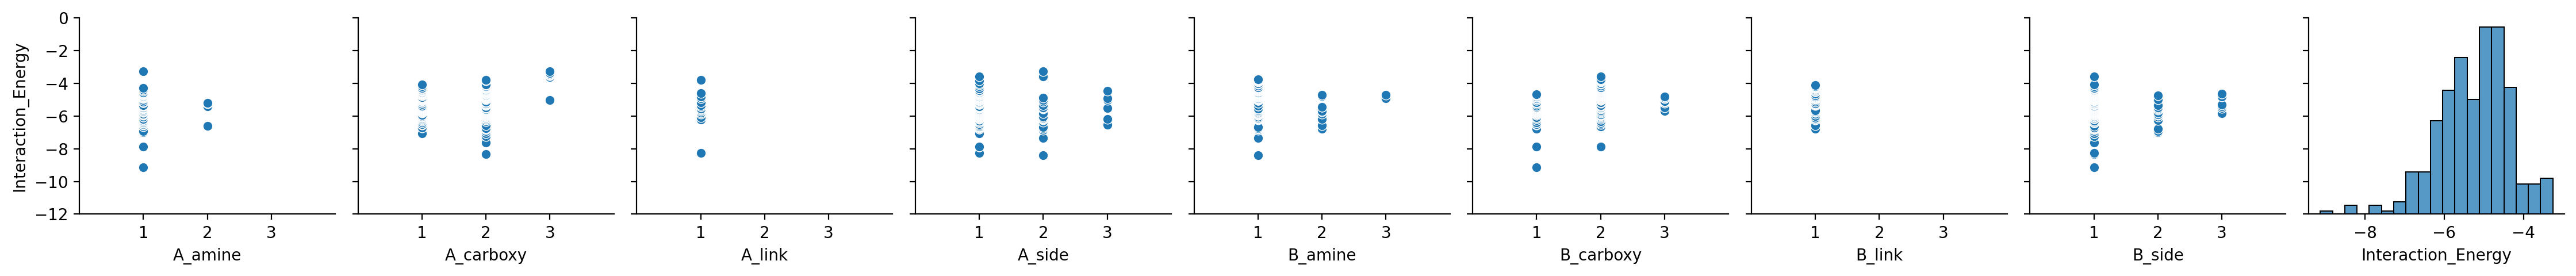

In [96]:
g=sns.pairplot(data=site_df,y_vars=['Interaction_Energy'])

for i in range(len(sitelist)):
    ax=g.axes[0,i]
    ax.set_xticks([1,2,3])
    ax.set_xticklabels([1,2,3])
    ax.set_xlim(0,4)
    ax.set_ylim(-12,0)
plt.tight_layout()
# plt.savefig('pairplot.png',dpi=300,bbox_inches='tight')
plt.show()

In [97]:
SerDF=site_df.loc[[i for i in site_df.index if 'Serine-' in i]]

SerList=[]
SerDict={}
for i in SerDF.index:
    subdf=SerDF[sitelist].loc[i]
    SerList.append(['/'.join(subdf.dropna().index),SerDF['Interaction_Energy'].loc[i]])
    

for i in set(np.array(SerList)[:,0]):
    SerDict[i]=[IE for nam,IE in SerList if nam==i]    

SerInt=pd.DataFrame.from_dict(SerDict,orient='index').T        


In [98]:
AspDF=site_df.loc[[i for i in site_df.index if 'Asparagine-' in i]]

AspList=[]
AspDict={}
for i in AspDF.index:
    subdf=AspDF[sitelist].loc[i]
    AspList.append(['/'.join(subdf.dropna().index),AspDF['Interaction_Energy'].loc[i]])
    

for i in set(np.array(AspList)[:,0]):
    AspDict[i]=[IE for nam,IE in AspList if nam==i]    
    
AspInt=pd.DataFrame.from_dict(AspDict,orient='index').T   



/var/folders/px/qyhp9b8j4bb0z5wgydzgkpxw0000gn/T/ipykernel_3251/3683731106.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation = 90, ha="center")
/var/folders/px/qyhp9b8j4bb0z5wgydzgkpxw0000gn/T/ipykernel_3251/3683731106.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation = 90, ha="center")


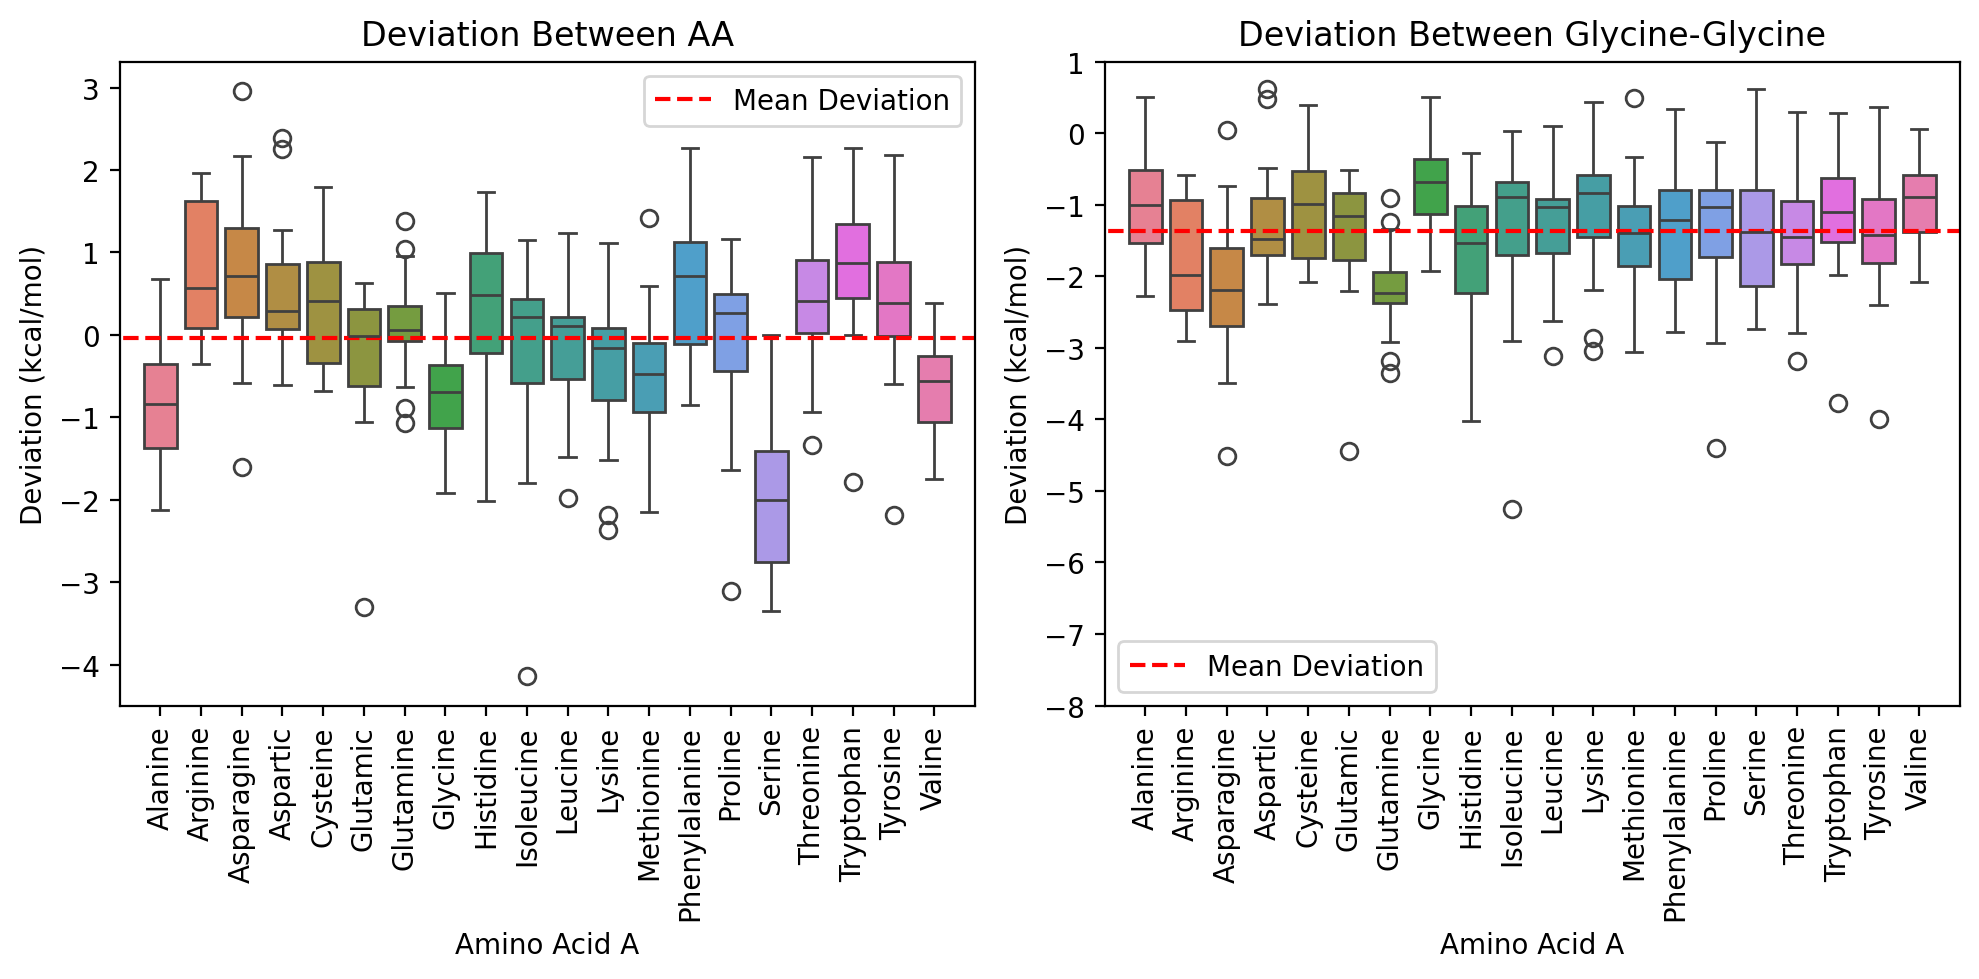

In [99]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
sns.boxplot(data=IE_df.astype(float),ax=ax1)
ax1.hlines(np.mean(IE_df.values.flatten()),-2,20,color='red',linestyles='--',label='Mean Deviation')
ax1.legend()
ax1.set_xlim(-1,20)
ax2.set_ylim(-5,9)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation = 90, ha="center")
ax1.set_title('Deviation Between AA')
ax1.set_xlabel('Amino Acid A')
ax1.set_ylabel('Deviation (kcal/mol)')

sns.boxplot(data=glygly_df.astype(float),ax=ax2)
ax2.hlines(np.mean(glygly_df.values.flatten()),-2,20,color='red',linestyles='--',label='Mean Deviation')
ax2.legend()
ax2.set_xlim(-1,20)
ax2.set_ylim(-8,1)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation = 90, ha="center")
ax2.set_title('Deviation Between Glycine-Glycine')
ax2.set_xlabel('Amino Acid A')
ax2.set_ylabel('Deviation (kcal/mol)')
plt.tight_layout()
# plt.savefig('deviation_boxplots.png',dpi=300,bbox_inches='tight')
plt.tight_layout()

In [100]:
# from mpl_toolkits.mplot3d import Axes3D
# from matplotlib.colors import ListedColormap
# # axes instance
# fig, ax = plt.subplots(subplot_kw={"projection": "3d"})


# # plot
# # sc = ax.scatter(unX['level_0'].values, unX['level_1'].values, unX[0].values, s=40,c=unX[0].values, marker='o', cmap=cmap, alpha=1)
# X=Y=range(len(AAs))
# X, Y = np.meshgrid(X, Y)
# sc = ax.plot_surface(X,Y, unX[0].values.reshape(20,20), cmap=sns.cm.rocket_r)
# fig.colorbar(sc, shrink=0.5, aspect=5)

# ax.set_xlabel('Amino Acid A')
# ax.set_xticks(range(len(AAs)))
# ax.set_xticklabels(AAs)
# ax.set_yticks(range(len(AAs)))
# ax.set_yticklabels(AAs)
# ax.set_ylabel('Amino Acid B')
# ax.set_zlabel('Interaction Energy (kcal/mol)')
# plt.tight_layout()
# plt.show()

In [101]:
# # Create the MolGraph object
# mg = MolGraph()

# # Read the data from the .xyz file
# mg.read_xyz(monomerfiles[0])


# # Convert the molecular graph to the NetworkX graph
# G = to_networkx_graph(mg)

# # G.nodes(data=True),G.edges(data=True)

In [102]:
# from rdkit.Chem import rdFingerprintGenerator
# mols=[Chem.MolFromSmiles(list(pybel.readfile('xyz',m))[0].write().split('\t')[0]) for m in monomerfiles]
# fpgen = rdFingerprintGenerator.GetMorganGenerator(radius=6)

# # info={}
# # X = np.vstack([fpgen.GetFingerprint(mol) for mol in mols ])

# fps = [MACCSkeys.GenMACCSKeys(x) for x in mols]
# X=np.vstack([f.ToList() for f in fps])
# Y=y.values

# keys=pd.read_excel('MACCS_keys_example.xlsx',index_col='Key').drop(columns=['Unnamed: 0'])

# mol_keys=[idx for idx, i in enumerate(X[0]) if i==1]

# {str(keys.loc[idx].values[0]):i for idx, i in enumerate(np.count_nonzero(X,axis=0)) if i!=0}

In [103]:

# sns.heatmap([[DataStructs.TanimotoSimilarity(i,j) for i in fps] for j in fps],vmin=0,vmax=1,cmap=sns.cm.rocket_r)
# plt.show()

In [104]:
# Draw.MolsToGridImage(mols,molsPerRow=10, subImgSize=(300,300))